In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr
from matplotlib.pyplot import rc_context
from sklearn import metrics

import seaborn as sns
import sys
import os

sys.path.append('../../Code/')
from utils import read_dataset_log
from starcat import starCAT
from scipy.stats import fisher_exact

In [2]:
figdir = '../../Figures/Components'

In [3]:
import gseapy as gp


In [4]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [3]:
! pip list

Package                   Version
------------------------- --------------
anndata                   0.10.9
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array_api_compat          1.8
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
backports.tarfile         1.2.0
beautifulsoup4            4.12.3
bleach                    6.1.0
blinker                   1.8.2
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
cloudpickle               3.0.0
cna                       0.1.6
cnmf                      1.5.4
colorama                  0.4.6
colorcet                  3.1.0
comm                      0.2.2
contourpy                 1.2.1
cryptography              43.0.0
cycler             

In [4]:
! conda info


     active environment : /data/srlab1/mcurtis/miniforge3/envs/py310
    active env location : /data/srlab1/mcurtis/miniforge3/envs/py310
            shell level : 1
       user config file : /PHShome/mc1070/.condarc
 populated config files : /usr/share/conda/condarc.d/defaults.yaml
                          /PHShome/mc1070/.condarc
          conda version : 4.6.14
    conda-build version : not installed
         python version : 3.6.8.final.0
       base environment : /usr  (read only)
           channel URLs : https://conda.anaconda.org/r/linux-64
                          https://conda.anaconda.org/r/noarch
                          https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://conda.anaconda.org/bioconda/linux-64
                          https://conda.anaconda.org/bioconda/noarch
                          https://repo.anaconda.com/pkgs/main/linux-64
                        

In [5]:
comp = {}

# AIM-Seq

## compute scores

In [6]:
dataset = 'Stimseq'

dataset_name = 'AIM-Seq'

In [7]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

cgep_info = read_dataset_log('cGEP_Name')
name_map = dict(zip(cgep_info['cGep_Name'], cgep_info['Short_Name']))

In [129]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
lineage_gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t')['0']
lineage_gating = lineage_gating.rename('Gating')
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')

usage.columns = usage.columns.map(name_map)

/tmp/ipykernel_222298/903360486.py:4: DtypeWarning: Columns (2,26) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')


In [189]:
# activation_fn = params.loc[dataset, 'activation_score_fn']
# activation = pd.read_csv(activation_fn, index_col = 0, sep = '\t')

In [330]:
params.loc[dataset, 'tcat_fn']

'/data/srlab1/TCAT/Data/PerDataset/Stimseq/TCAT.20231201.tsv'

In [331]:
display(usage.head(2))
display(lineage_gating.head(2))
display(meta.head(2))

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
3_AAACCTGAGACCGGAT,6.288362e-10,4.555608e-18,1.077129e-08,0.000004,0.000365,4.062416e-07,4.638827e-08,8.984696e-07,3.357723e-07,9.335903e-08,...,0.000024,6.962302e-08,2.923198e-11,5.481779e-09,0.000002,1.383841e-07,0.000587,4.988998e-05,2.603514e-06,0.000006
3_AAACCTGAGAGGGCTT,9.166205e-07,1.658563e-04,1.416423e-05,0.000005,0.000062,3.205029e-04,6.950268e-06,4.306786e-06,3.140137e-05,1.487326e-05,...,0.000059,1.125588e-06,5.498743e-05,2.846343e-05,0.000126,1.479679e-05,0.000141,2.408441e-07,1.606135e-07,0.000074


3_AAACCTGAGACCGGAT       CD4_CM
3_AAACCTGAGAGGGCTT    CD4_Naive
Name: Gating, dtype: object

,barcode,BRI,Run,Well,Batch,Biobank_ID,Sort_Status,HTO_Status,Demuxlet_Assignment,Total_RNA_Count,...,A_Num_Productive_In_Barcode,A_Has_Unproductive,B_Possible_TCR_Doublet,A_Possible_TCR_Doublet,DEMUX_BEST_Category,Hashtag1,Hashtag2,Hashtag3,n_counts,leiden
3_AAACCTGAGACCGGAT,AAACCTGAGACCGGAT-1,2248_hashing,2,1,3,10042029,+,Hashtag3 (+),SNG,1443,...,NaN,NaN,NaN,NaN,SNG,8,19,4305,1443.0,7
3_AAACCTGAGAGGGCTT,AAACCTGAGAGGGCTT-1,2248_hashing,2,1,3,10057029,U,Hashtag1 (U),SNG,3508,...,1.0,True,Productive Singleton,Productive Singleton,SNG,391,61,138,3508.0,4


In [332]:
cat = starCAT(reference='TCAT.V1', cachedir='../../../Data/Misc/cache')

Using reference from starCAT database
Loading reference from existing cache file for reference TCAT.V1


In [333]:
cat.usage = usage
cat.usage_norm = usage.div(usage.sum(axis=1), axis=0).copy()
scores = cat.compute_addon_scores()

/PHShome/mc1070/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [334]:
# scores.to_csv('/data/srlab1/TCAT/Data/PerDataset/Stimseq/TCAT_scores.20231201.tsv')

In [130]:
scores = pd.read_csv('../../Data/PerDataset/Stimseq/TCAT_scores.20231201.tsv', index_col = 0, 
                    sep = ',')

In [62]:
scores

,ASA,Proliferation,ASA_binary,Proliferation_binary,Multinomial_Label
3_AAACCTGAGACCGGAT,0.000134,0.000322,False,False,CD4_EM
3_AAACCTGAGAGGGCTT,0.008031,0.001938,False,False,CD4_Naive
3_AAACCTGAGAGTCTGG,0.125305,0.019477,True,False,CD4_EM
3_AAACCTGAGCTAGCCC,0.019631,0.016048,False,False,CD4_CM
3_AAACCTGAGCTGCCCA,0.151857,0.020850,True,False,CD4_EM
...,...,...,...,...,...
2_TTTGTCATCAGGCCCA,0.017665,0.017239,False,False,CD4_CM
2_TTTGTCATCATATCGG,0.014672,0.004241,False,False,CD8_TEMRA
2_TTTGTCATCATTATCC,0.002110,0.001549,False,False,CD8_Naive
2_TTTGTCATCGGCTACG,0.003428,0.000869,False,False,CD4_Naive


## compute gene set activation scores

In [8]:
import re

In [70]:
gsets = gp.parser.read_gmt('../../Data/Misc/activationgenesets.v2024.1.Hs_3000.gmt')

include_terms = r'ACTIVA'
include_terms2= r'CD8_TCELL|CD8|CD4_TCELL|CD4|TREG|TH17|TH1|TH2|TFH|TCELL|T_CELL'
exclude_terms = r'BCELL|MYELOID|THYMOCYTE|INNATE_LYMPHOID_CELL|POS_DC|WEAK_DC|CD40|PBMC_VS_MEM_CD4_TCELL|HEMATOPOIETIC_STEM_CELL|LYMPHOID_PRIMED_MPP|BASOPHIL|_DC_VS_|EOSINOPHI|MAC_VS|MAST_CELL|NEUTROPHIL|NKCELL|PROGENITOR|LSK|LIN_NEG_VS|NKTCELL|ERYTHTROBLAST|MONO_MAC|NKT|NK_T_CELL'

In [172]:
len(gsets)

3061

In [71]:
gsetnames_filt = [
    gs for gs in gsets.keys()
    if re.search(include_terms, gs) and re.search(include_terms2, gs) and not re.search(exclude_terms, gs)
]

In [72]:
gsetnames_filt = ['GOBP_ACTIVATED_T_CELL_PROLIFERATION',
 # 'GOBP_ACTIVATION_INDUCED_CELL_DEATH_OF_T_CELLS',
 # 'GOBP_NEGATIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION',
 # 'GOBP_NEGATIVE_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_NEGATIVE_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_NEGATIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION',
 # 'GOBP_POSITIVE_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_GAMMA_DELTA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_GAMMA_DELTA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_T_CELL_ACTIVATION_VIA_T_CELL_RECEPTOR_CONTACT_WITH_ANTIGEN_BOUND_TO_MHC_MOLECULE_ON_ANTIGEN_PRESENTING_CELL',
 # 'GSE13738_RESTING_VS_BYSTANDER_ACTIVATED_CD4_TCELL_DN',
 # 'GSE13738_RESTING_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
 # 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_UP',
 # 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_DN',
 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_UP',
 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_UP',
 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_UP',
 'GSE15659_RESTING_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_RESTING_VS_ACTIVATED_TREG_UP',
 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN',
 # 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_UP',
 # 'HP_ABNORMAL_T_CELL_ACTIVATION',
 # 'POSITIVE_REGULATION_OF_T_CELL_ACTIVATION',
 # 'WP_MODULATORS_OF_TCR_SIGNALING_AND_T_CELL_ACTIVATION',
 'WP_TCELL_ACTIVATION_SARSCOV2']


# ['GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
#                   'GOBP_ACTIVATED_T_CELL_PROLIFERATION',
#                   'WP_TCELL_ACTIVATION_SARSCOV2'
# ]

In [64]:
adata = sc.read(params.loc[dataset, 'raw_counts_filt_fn'])
adata.var.index  = adata.var['gene_name'].astype('str')
adata.var_names_make_unique()

Only considering the two last: ['.doubletfilt', '.h5ad'].
Only considering the two last: ['.doubletfilt', '.h5ad'].


In [65]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [66]:
gset_size = 20

In [67]:
gsetnames_filt

['GOBP_ACTIVATED_T_CELL_PROLIFERATION',
 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN',
 'GSE15659_RESTING_VS_ACTIVATED_TREG_DN',
 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN',
 'WP_TCELL_ACTIVATION_SARSCOV2']

In [73]:
for gs in gsetnames_filt:
    print(len(gsets[gs]))
    sc.tl.score_genes(adata, gsets[gs], score_name = gs, random_state = 0)
    
    g_overlap = adata.var.index.intersection(gsets[gs])
    adata.obs[f'{gs}_Mean'] = adata[:, g_overlap].X.mean(axis = 1)

49
200
198
198
       'TCP10L3', 'WARS1', 'ZDHHC8BP', 'ZNF663P'],
      dtype='object')
198
       'TCP10L3', 'WARS1', 'ZNF861P'],
      dtype='object')
197
       'ZNF861P'],
      dtype='object')
198
       'SNORA65', 'WARS1', 'ZDHHC8BP', 'ZNF663P'],
      dtype='object')
199
88


In [74]:
adata.obs[gsetnames_filt + [f'{gs}_Mean' for gs in gsetnames_filt]].to_csv('../../Data/PerDataset/Stimseq/gene_scores_activation.tsv', sep = '\t')

## compare to Azimuth, ProjectTILs, symphony, etc.

In [136]:
az_fn = '../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.Azimuth.tsv'
az_res = pd.read_csv(az_fn, index_col = 0, sep = '\t')
az_res = az_res[az_res.columns[az_res.columns.str.contains('predicted.celltype')]]

/tmp/ipykernel_222298/428521550.py:2: DtypeWarning: Columns (5,29) have mixed types. Specify dtype option on import or set low_memory=False.
  az_res = pd.read_csv(az_fn, index_col = 0, sep = '\t')


In [137]:
az_res.head(3)

,predicted.celltype.l1.score,predicted.celltype.l1,predicted.celltype.l2.score,predicted.celltype.l2,predicted.celltype.l3.score,predicted.celltype.l3
3_AAACCTGAGACCGGAT,0.974819,CD4 T,0.935026,CD4 TCM,0.811141,CD4 TCM_1
3_AAACCTGAGAGGGCTT,1.000000,CD4 T,0.855605,CD4 Naive,0.855605,CD4 Naive
3_AAACCTGAGAGTCTGG,0.806533,CD4 T,0.779576,CD4 TCM,0.440375,CD4 TCM_3


In [138]:
sym_fn = '../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.symphony.tsv'
sym_res = pd.read_csv(sym_fn, index_col = 0, sep = '\t')


In [139]:
sym_res.head(3)

,cell_type_pred_knn,cell_type_pred_knn_prob
3_AAACCTGAGACCGGAT,CD4 TEM,0.6
3_AAACCTGAGAGGGCTT,CD4 Naive,1.0
3_AAACCTGAGAGTCTGG,CD4 TCM,1.0


In [140]:
ptils_cd4_fn = '../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.ProjectTILsCD4.tsv'
ptils_cd4 = pd.read_csv(ptils_cd4_fn, index_col = 0, sep = '\t')
ptils_cd4.columns = 'ProjecTILsCD4_' + ptils_cd4.columns

ptils_cd8_fn = '../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.ProjectTILsCD8.tsv'
ptils_cd8 = pd.read_csv(ptils_cd8_fn, index_col = 0, sep = '\t')
ptils_cd8.columns = 'ProjecTILsCD8_' + ptils_cd8.columns

ptils_allt_fn = '../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.ProjectTILsAllTMouse.tsv'
ptils_allt = pd.read_csv(ptils_allt_fn, index_col = 0, sep = '\t')
ptils_allt.columns = 'ProjecTILsAllT_' + ptils_allt.columns

In [141]:
ptils_allt.head(2)

,ProjecTILsAllT_functional.cluster,ProjecTILsAllT_functional.cluster.conf
3_AAACCTGAGACCGGAT,CD8_NaiveLike,0.649674
3_AAACCTGAGAGGGCTT,CD8_NaiveLike,0.884838


In [142]:
## Figure out why missing metadata later
az_res.shape, sym_res.shape, meta.shape, scores.shape

((43222, 6), (43222, 2), (42370, 74), (43222, 5))

In [143]:
act_gsets_fn = '../../Data/PerDataset/Stimseq/gene_scores_activation.tsv'
act_gsets = pd.read_csv(act_gsets_fn, index_col = 0, sep = '\t')
gsetnames = act_gsets.columns[~(act_gsets.columns.str.endswith('_Mean'))]
act_gsets = act_gsets[gsetnames]

In [15]:
gsetnames

Index(['GOBP_ACTIVATED_T_CELL_PROLIFERATION',
       'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
       'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
       'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN',
       'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN',
       'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN',
       'GSE15659_RESTING_VS_ACTIVATED_TREG_DN',
       'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN',
       'WP_TCELL_ACTIVATION_SARSCOV2'],
      dtype='object')

In [16]:
len(gsetnames)

9

In [107]:
from functools import reduce

In [144]:
lineage_gating_class = pd.Series(np.nan, index = lineage_gating.index)
lineage_gating_class.loc[lineage_gating.str.contains('CD4')] = 'CD4 Conv'
lineage_gating_class.loc[lineage_gating=='Treg'] = 'CD4 Treg'
lineage_gating_class.loc[lineage_gating.str.contains('CD8')] = 'CD8 Conv'
lineage_gating_class.loc[lineage_gating_class.isna()] = 'Other'
lineage_gating_class.name = 'Gating_Class'

/tmp/ipykernel_222298/1899751058.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CD4 Conv' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  lineage_gating_class.loc[lineage_gating.str.contains('CD4')] = 'CD4 Conv'


In [145]:
# comp_all = reduce(lambda l, r: pd.merge(l, r, left_index = True, right_index = True, how='inner'), 
#                   [meta[meta['Sort_Status'].isin(['+', '-'])], scores, az_res, sym_res, ptils_cd4, ptils_cd8, ptils_allt,
#                    lineage_gating])
comp_all = reduce(lambda l, r: pd.merge(l, r, left_index = True, right_index = True, how='inner'), 
                  [meta, scores, az_res, sym_res, ptils_cd4, ptils_cd8, ptils_allt,
                   lineage_gating, lineage_gating_class, act_gsets])

In [146]:
comp_all['predicted.celltype.l2_renamed'] = 'Azimuth_' + comp_all['predicted.celltype.l2']
comp_all['Multinomial_Label_renamed'] = 'TCATMultiPred_' + comp_all['Multinomial_Label']
comp_all['cell_type_pred_knn_renamed'] = 'Symphony_' + comp_all['cell_type_pred_knn']

In [147]:
comp_all['ProjecTILsCD8_functional.cluster_renamed'] = 'ProjecTILsCD8_' + comp_all['ProjecTILsCD8_functional.cluster']
comp_all['ProjecTILsCD4_functional.cluster_renamed'] = 'ProjecTILsCD4_' + comp_all['ProjecTILsCD4_functional.cluster']
comp_all['ProjecTILsAllT_functional.cluster_renamed'] = 'ProjecTILsAllT_' + comp_all['ProjecTILsAllT_functional.cluster']


In [148]:
comp_all['ASA_binary_renamed'] = ''
comp_all.loc[comp_all['ASA_binary']==True, 'ASA_binary_renamed'] = 'ASA+'
comp_all.loc[comp_all['ASA_binary']==False, 'ASA_binary_renamed'] = 'ASA-'

In [149]:
comp[dataset] = comp_all

In [88]:
comp_all.shape

(42370, 120)

In [243]:
scores.shape

(43222, 5)

In [135]:
comp_all.head(2)

,barcode,BRI,Run,Well,Batch,Biobank_ID,Sort_Status,HTO_Status,Demuxlet_Assignment,Total_RNA_Count,...,GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,GOBP_ACTIVATED_T_CELL_PROLIFERATION,WP_TCELL_ACTIVATION_SARSCOV2,predicted.celltype.l2_renamed,Multinomial_Label_renamed,cell_type_pred_knn_renamed,ProjecTILsCD8_functional.cluster_renamed,ProjecTILsCD4_functional.cluster_renamed,ProjecTILsAllT_functional.cluster_renamed,ASA_binary_renamed
3_AAACCTGAGACCGGAT,AAACCTGAGACCGGAT-1,2248_hashing,2,1,3,10042029,+,Hashtag3 (+),SNG,1443,...,0.205458,0.077794,0.156478,Azimuth_CD4 TCM,TCATMultiPred_CD4_EM,Symphony_CD4 TEM,ProjecTILsCD8_CD8.NaiveLike,ProjecTILsCD4_CD4.Tfh,ProjecTILsAllT_CD8_NaiveLike,ASA-
3_AAACCTGAGAGGGCTT,AAACCTGAGAGGGCTT-1,2248_hashing,2,1,3,10057029,U,Hashtag1 (U),SNG,3508,...,-0.125296,-0.046885,-0.139716,Azimuth_CD4 Naive,TCATMultiPred_CD4_Naive,Symphony_CD4 Naive,ProjecTILsCD8_CD8.NaiveLike,ProjecTILsCD4_CD4.NaiveLike,ProjecTILsAllT_CD8_NaiveLike,ASA-


In [114]:
comp_all = comp[dataset]

### benchmark lineage across all cells

In [115]:
for col in ['Multinomial_Label_renamed', 'predicted.celltype.l2_renamed', 'cell_type_pred_knn_renamed',
           # 'ProjecTILsCD8_functional.cluster_renamed', 'ProjecTILsCD4_functional.cluster_renamed',
           'ProjecTILsAllT_functional.cluster_renamed']:
    comp_all[col] = pd.Categorical(comp_all[col])

In [978]:
# aims = ['U', '-', '+']

In [116]:
ctbs = [pd.crosstab([comp_all['Multinomial_Label_renamed']], 
                [comp_all['Gating']], dropna=False),
     pd.crosstab(comp_all['predicted.celltype.l2_renamed'], 
                [ comp_all['Gating']], dropna=False),
     pd.crosstab(comp_all['cell_type_pred_knn_renamed'], 
                [ comp_all['Gating']], dropna=False),
     # pd.crosstab(comp_all['ProjecTILsCD8_functional.cluster_renamed'], 
     #            [ comp_all['Gating']], dropna=False),
     # pd.crosstab(comp_all['ProjecTILsCD4_functional.cluster_renamed'], 
     #            [ comp_all['Gating']], dropna=False),
     pd.crosstab(comp_all['ProjecTILsAllT_functional.cluster_renamed'], 
                [ comp_all['Gating']], dropna=False),
   ]

In [117]:
ncells_comp = pd.DataFrame()
ncells_comp_norm = pd.DataFrame()
odds_comp = pd.DataFrame()
p_comp = pd.DataFrame()

In [118]:
for ctb in ctbs:
    ncells_comp = pd.concat([ncells_comp, ctb], axis = 0)
    ncells_comp_norm = pd.concat([ncells_comp_norm, ctb.div(ctb.sum(), axis = 1)], axis = 0)

In [119]:
odds_comp = pd.DataFrame()
p_comp = pd.DataFrame()
for ctb in ctbs:
    odds_dat = pd.DataFrame(1, index = ctb.index, columns = ctb.columns)
    p_dat = pd.DataFrame(1, index = ctb.index, columns = ctb.columns)

    for gate in ctb.columns:
        for label in ctb.index:

            a = ctb.loc[label, gate]
            b = ctb.loc[:, gate].drop(label).sum()
            c = ctb.loc[label, :].drop(gate).sum()
            d = ctb.drop(label).drop(gate, axis = 1).sum().sum()

            odds_ratio, p = fisher_exact(np.array([a, b, c, d]).reshape(2, 2))
            odds_dat.loc[label, gate] = odds_ratio
            p_dat.loc[label, gate] = p
            
    odds_comp = pd.concat([odds_comp, odds_dat], axis = 0)
    p_comp = pd.concat([p_comp, p_dat], axis = 0)

/tmp/402154.tmpdir/ipykernel_286447/1538203801.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.64096282327379' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  odds_dat.loc[label, gate] = odds_ratio
/tmp/402154.tmpdir/ipykernel_286447/1538203801.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.061317413987007e-141' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p_dat.loc[label, gate] = p
/tmp/402154.tmpdir/ipykernel_286447/1538203801.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.795799345136633' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  odds_dat.loc[label, gate] = odds_ratio
/tmp/402154.tmpdi

In [120]:
label_fontsize = 20
tick_fontsize = 16

Text(0.5, 160.4444444444444, 'Gating')

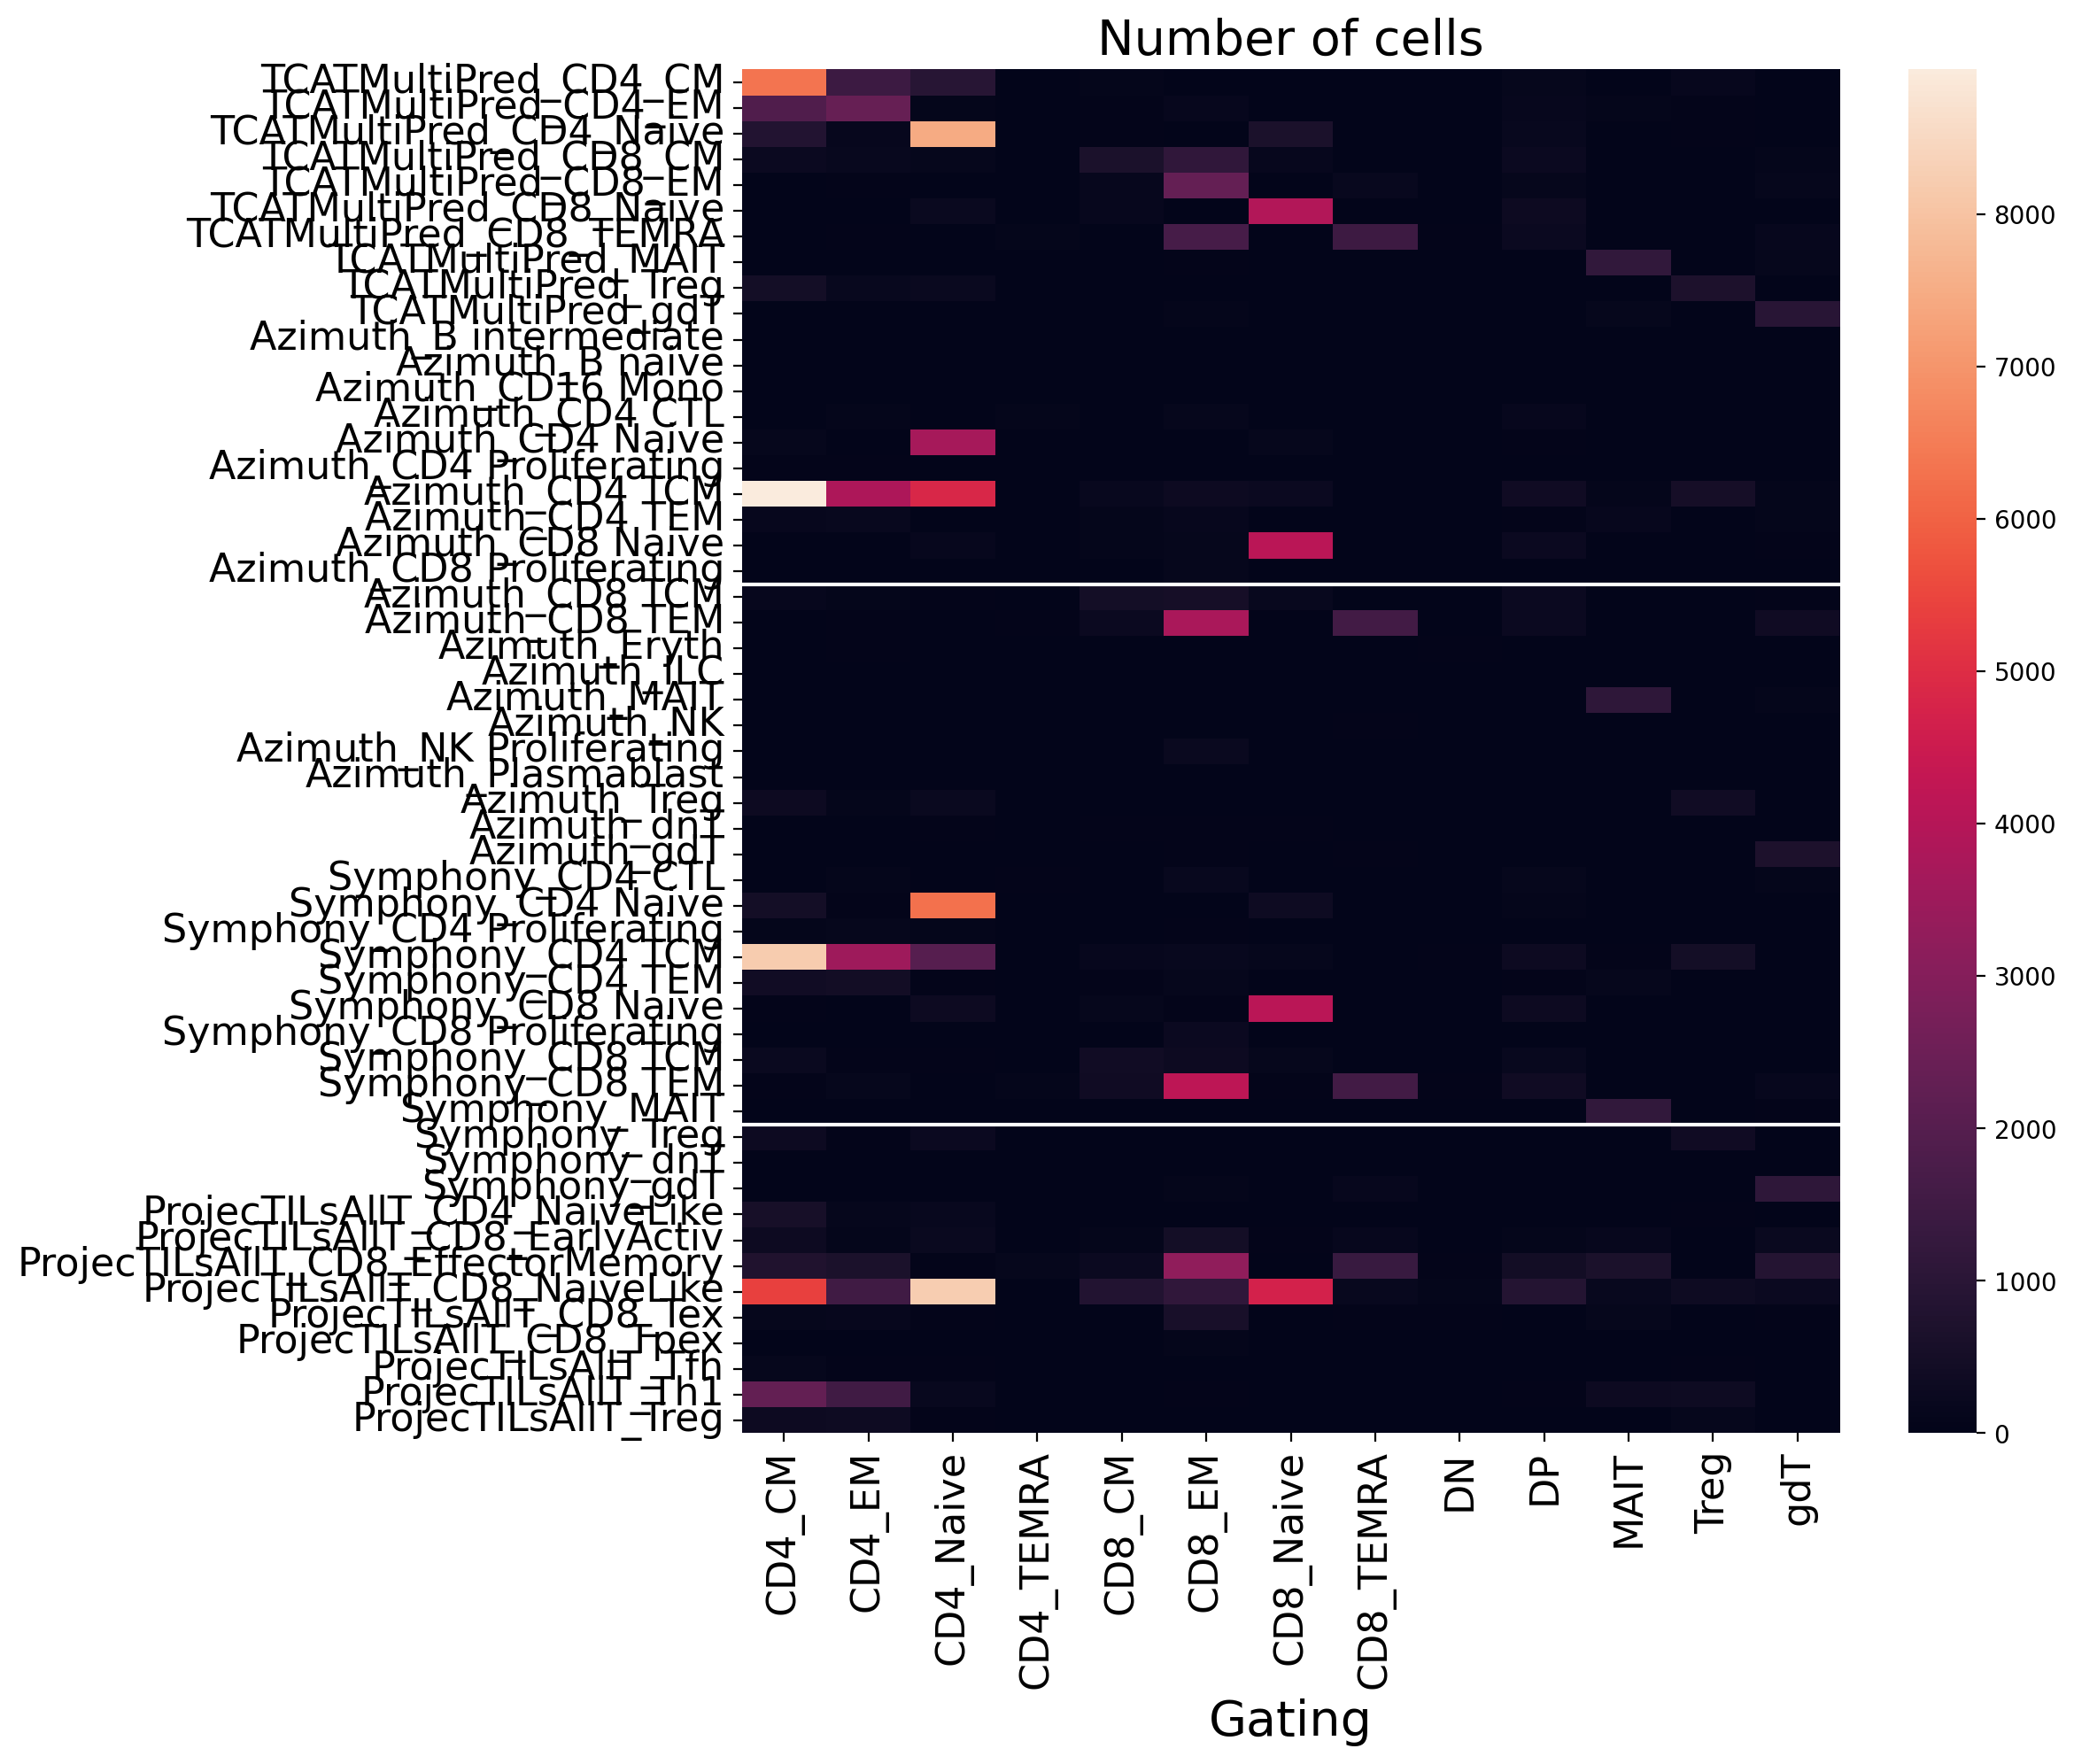

In [30]:
fig, ax = plt.subplots(dpi = 200, figsize = (10, 10))

sns.heatmap(ncells_comp, ax = ax)
ax.hlines(y = 20, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 41, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 54, xmin = 0, xmax = 40, color = 'white')
ax.set_title('Number of cells', fontsize = label_fontsize)
ax.tick_params('both', labelsize = tick_fontsize)
ax.set_xlabel(ax.get_xlabel(), fontsize = label_fontsize)

In [121]:
row_order = ['TCATMultiPred_CD4_EM',
 'TCATMultiPred_CD4_CM',
 'TCATMultiPred_CD8_CM',
 'TCATMultiPred_MAIT',
 'TCATMultiPred_CD8_Naive',
 'TCATMultiPred_CD8_EM',
 'TCATMultiPred_CD8_TEMRA',
 'TCATMultiPred_Treg',
 'TCATMultiPred_CD4_Naive',
 'TCATMultiPred_gdT',
]
#list(comp_all['Multinomial_Label_renamed'].unique())  #[[(l, 'ASA+'), (l, 'ASA-')] for l in comp_all['Multinomial_Label_renamed'].unique()]
#row_order = [item for sublist in row_order for item in sublist]

In [122]:
a_order = ['Azimuth_CD4 TEM', 'Azimuth_CD4 TCM', 'Azimuth_CD4 CTL', 'Azimuth_CD8 TCM',
                         'Azimuth_MAIT', 'Azimuth_CD8 Naive', 'Azimuth_CD8 TEM',
                         'Azimuth_Treg', 'Azimuth_CD4 Naive', 'Azimuth_gdT', 'Azimuth_dnT',
                         'Azimuth_CD4 Proliferating', 'Azimuth_CD8 Proliferating',
                    'Azimuth_ILC', 'Azimuth_NK', 'Azimuth_NK Proliferating',
                         'Azimuth_CD16 Mono', 'Azimuth_B naive', 'Azimuth_B intermediate',
                        'Azimuth_Eryth', 'Azimuth_Plasmablast']

In [123]:
s_order = [a.replace('Azimuth', 'Symphony') for a in a_order if a.replace('Azimuth', 'Symphony') in 
           comp_all['cell_type_pred_knn_renamed'].unique()]

In [124]:
p_order = ['ProjecTILsAllT_Th1', 
           'ProjecTILsAllT_Tfh',
        'ProjecTILsAllT_CD8_EarlyActiv',
       'ProjecTILsAllT_CD8_EffectorMemory', 
       'ProjecTILsAllT_CD8_Tex',
       'ProjecTILsAllT_CD8_Tpex',
        'ProjecTILsAllT_CD8_NaiveLike', 
        'ProjecTILsAllT_Treg',
        'ProjecTILsAllT_CD4_NaiveLike',
          ]

In [506]:
set(comp_all['ProjecTILsAllT_functional.cluster_renamed'].unique()).difference(p_order)

set()

In [507]:
set(p_order).difference(comp_all['ProjecTILsAllT_functional.cluster_renamed'].unique())

set()

In [125]:
row_order = row_order + a_order + s_order + p_order

In [126]:
# col_order = [c[0] for n, c in enumerate(col_order) if n%2==0]

In [127]:
col_order = ['CD4_EM',
 'CD4_CM',
 'CD8_CM',
 'MAIT',
 'CD8_Naive',
 'CD8_EM',
 'CD8_TEMRA',
 'CD4_TEMRA',
 'Treg',
 'CD4_Naive',
 'gdT',
 'DN',
 'DP']


In [128]:
label_fontsize = 10
tick_fontsize = 8

In [129]:
row_order_renamed = [l.replace('TCATMultiPred_', '').replace('Azimuth_', '').replace('Symphony_', '').replace('ProjecTILsAllT_', '') 
 for l in row_order]

In [130]:
col_order_renamed = [c.replace('_', ' ') for c in col_order]

In [131]:
vmax = np.quantile(ncells_comp.unstack(), 0.99)
vmin = 0

Text(0.5, 1.0, 'Number of cells')

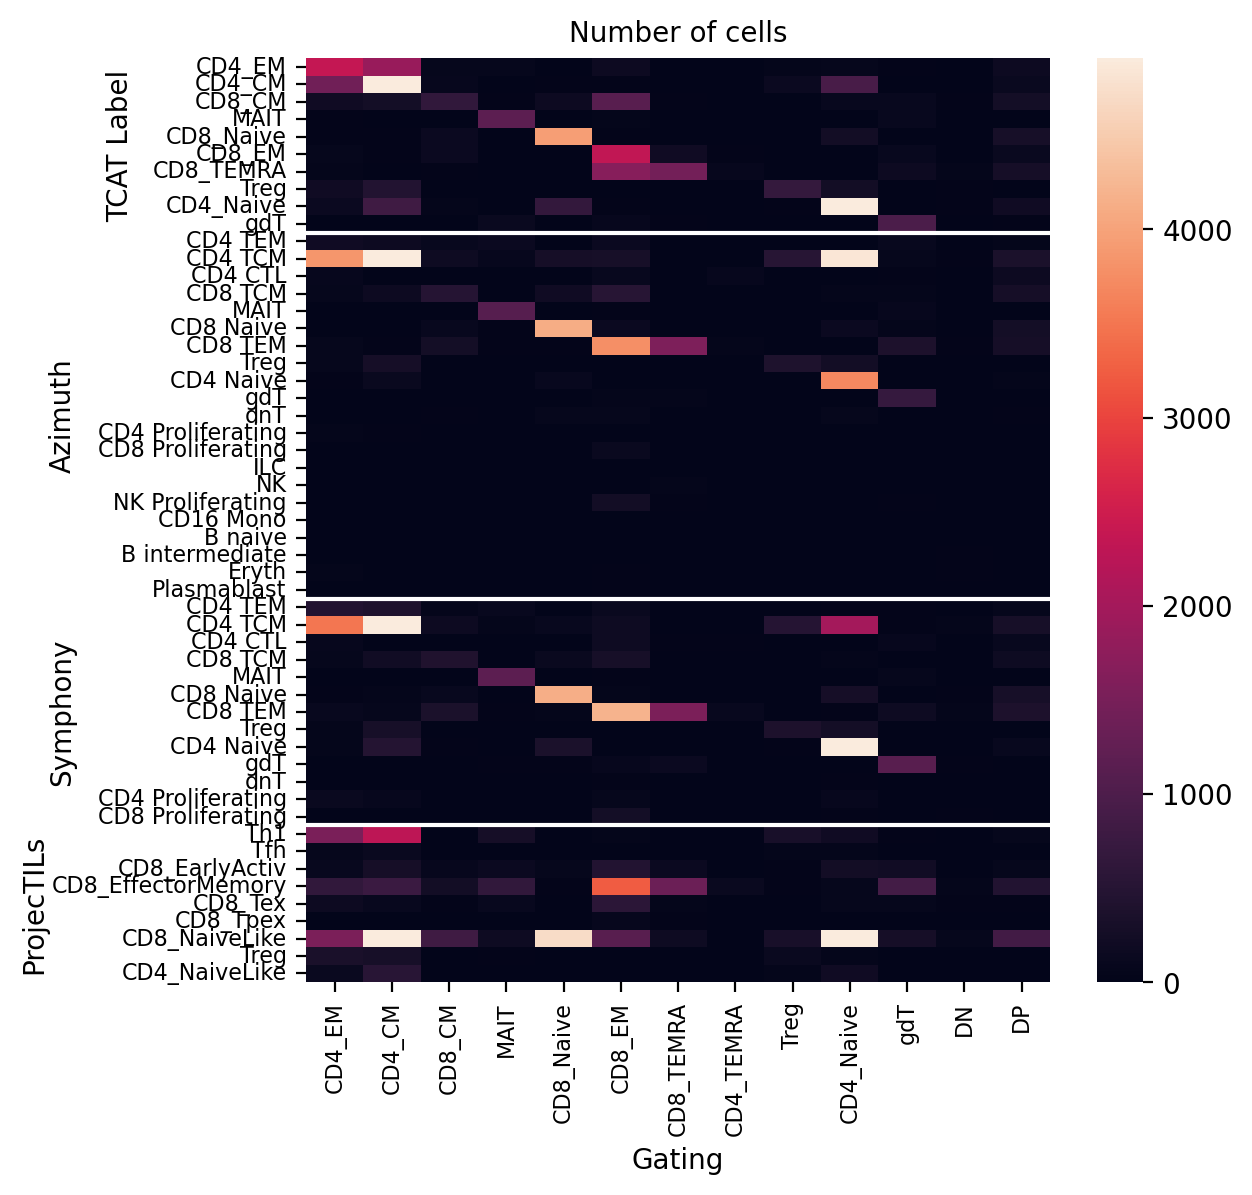

In [47]:
fig, ax = plt.subplots(dpi = 200, figsize = (6, 6), 
                      )

cbar =True 
sns.heatmap(ncells_comp.loc[row_order, col_order], cbar = cbar, 
            ax = ax, vmax = vmax, vmin = vmin)
ax.hlines(y = 10, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 31, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 44, xmin = 0, xmax = 40, color = 'white')
ax.text(-3.5, 5, 'TCAT Label', rotation = 90, va = 'center')
ax.text(-4.5, (31-10)/2 +10, 'Azimuth', rotation = 90, va = 'center')
ax.text(-4.5, (44-31)/2 +31, 'Symphony', rotation = 90, va = 'center')
ax.text(-5, (len(row_order)-44)/2 +44, 'ProjecTILs', rotation = 90, va = 'center')

ax.tick_params('both', labelsize = tick_fontsize)
ax.set_xlabel(ax.get_xlabel(), fontsize = label_fontsize)

ax.set_yticks(np.arange(0.5, 0.5+len(row_order_renamed)), row_order_renamed)
ax.set_title('Number of cells',  fontsize = label_fontsize)

In [132]:
vmax = np.quantile(ncells_comp_norm.unstack(), 0.99)
vmin = 0

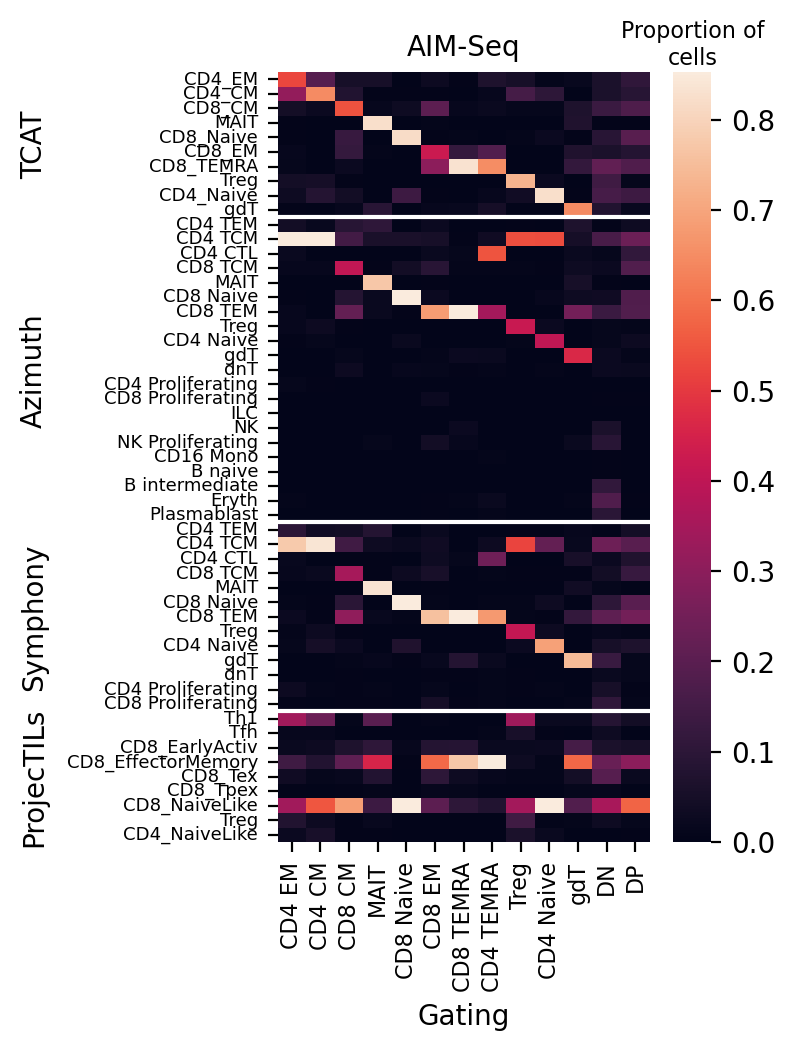

In [1001]:
fig, ax = plt.subplots(dpi = 200, figsize = (3, 5), 
                      )

cbar =True 
g = sns.heatmap(ncells_comp_norm.loc[row_order, col_order], cbar = cbar, 
            ax = ax, vmax = vmax, vmin = vmin)
ax.hlines(y = 10, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 31, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 44, xmin = 0, xmax = 40, color = 'white')
ax.text(-9, 5, 'TCAT', rotation = 90, va = 'center')
ax.text(-9, (31-10)/2 +10, 'Azimuth', rotation = 90, va = 'center')
ax.text(-9, (44-31)/2 +31, 'Symphony', rotation = 90, va = 'center')
ax.text(-9, (len(row_order)-44)/2 +44, 'ProjecTILs', rotation = 90, va = 'center')

ax.tick_params('y', labelsize = tick_fontsize-1.5)
ax.tick_params('x', labelsize = tick_fontsize)
ax.set_xlabel(ax.get_xlabel(), fontsize = label_fontsize)

ax.set_yticks(np.arange(0.5, 0.5+len(row_order_renamed)), row_order_renamed)
ax.set_xticks(np.arange(0.5, 0.5+len(col_order_renamed)), col_order_renamed)
# ax.set_title('%s\nProportion of cells' % dataset_name,  fontsize = label_fontsize)
ax.set_title('%s' % dataset_name,  fontsize = label_fontsize)
ax.text(1.115, 1.01, 'Proportion of\ncells', ha = 'center', transform=ax.transAxes,
       fontsize = label_fontsize-2)

plt.savefig(os.path.join(figdir, 'Revision_LineageBenchmarkHeatmap_Stimseq.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_LineageBenchmarkHeatmap_Stimseq.pdf'), bbox_inches="tight")
plt.show()

In [133]:
import itertools


import sklearn

In [135]:
gates_map = dict(zip(comp_all['Gating'].unique(), [None]*len(comp_all['Gating'].unique())))

gates_map['CD4_CM'] = [['CD4_CM'], ['CD4 TCM'], ['CD4 TCM'], None]
gates_map['CD4_Naive'] = [['CD4_Naive'], ['CD4 Naive'], ['CD4 Naive'], ['CD4_NaiveLike']]
gates_map['CD4_EM'] = [['CD4_EM'], ['CD4 TEM'], ['CD4 TEM'], ['Tfh', 'Th1']]
gates_map['MAIT'] = [['MAIT'], ['MAIT'], ['MAIT'], None]
gates_map['CD8_CM'] = [['CD8_CM'], ['CD8 TCM'], ['CD8 TCM'], None]
gates_map['CD8_EM'] = [['CD8_EM'], ['CD8 TEM'], ['CD8 TEM'], ['CD8_EffectorMemory']]
gates_map['gdT'] = [['gdT'], ['gdT'], ['gdT'], None]
gates_map['CD8_Naive'] = [['CD8_Naive'], ['CD8 Naive'], ['CD8 Naive'], ['CD8_NaiveLike']]
gates_map['Treg'] = [['Treg'], ['Treg'], ['Treg'], ['Treg']]
gates_map['CD8_TEMRA'] = [['CD8_TEMRA'], None, None, None]
gates_map['DP'] = [None, None, None, None]
gates_map['DN'] = [None, ['dnT'], ['dnT'], None]
gates_map['CD4_TEMRA'] = [None, None, None, None]

In [626]:
(comp['Stimseq']['Multinomial_Label'].unique(), comp['Stimseq']['predicted.celltype.l2'].unique(), 
comp['Stimseq']['cell_type_pred_knn'].unique(), comp['Stimseq']['ProjecTILsAllT_functional.cluster'].unique(), )

(array(['CD4_EM', 'CD4_Naive', 'CD4_CM', 'CD8_CM', 'MAIT', 'CD8_Naive',
        'CD8_EM', 'CD8_TEMRA', 'gdT', 'Treg'], dtype=object),
 array(['CD4 TCM', 'CD4 Naive', 'CD8 TCM', 'MAIT', 'CD4 TEM', 'CD8 TEM',
        'gdT', 'CD8 Naive', 'NK Proliferating', 'CD4 Proliferating',
        'B intermediate', 'Treg', 'Eryth', 'CD4 CTL', 'Plasmablast',
        'CD8 Proliferating', 'NK', 'dnT', 'B naive', 'CD16 Mono', 'ILC'],
       dtype=object),
 array(['CD4 TEM', 'CD4 Naive', 'CD4 TCM', 'MAIT', 'CD8 TEM', 'CD4 CTL',
        'gdT', 'CD8 TCM', 'CD8 Naive', 'CD8 Proliferating', 'Treg',
        'CD4 Proliferating', 'dnT'], dtype=object),
 array(['CD8_NaiveLike', 'Th1', 'CD4_NaiveLike', 'CD8_EarlyActiv',
        'CD8_EffectorMemory', 'Treg', 'CD8_Tex', 'Tfh', 'CD8_Tpex'],
       dtype=object))

In [137]:
accuracy = pd.DataFrame(np.nan, index = comp_all['Gating'].unique(), 
                        columns = ['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn',
                                  'ProjecTILsAllT_functional.cluster'])

In [138]:
comp_all['Multinomial_Label_PredRename'] = ''
comp_all['predicted.celltype.l2_PredRename'] = ''
comp_all['cell_type_pred_knn_PredRename'] = ''
comp_all['ProjecTILsAllT_functional.cluster_PredRename'] = ''

for gate_type in comp_all['Gating'].unique():
    gates = comp_all['Gating']==gate_type
    if gates_map[gate_type][0]:
        pred = comp_all['Multinomial_Label'].isin(gates_map[gate_type][0])
        accuracy.loc[gate_type, 'Multinomial_Label'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['Multinomial_Label'].isin(gates_map[gate_type][0]), 'Multinomial_Label_PredRename'] = gate_type

    if gates_map[gate_type][1]:
        pred = comp_all['predicted.celltype.l2'].isin(gates_map[gate_type][1])
        accuracy.loc[gate_type, 'predicted.celltype.l2'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['predicted.celltype.l2'].isin(gates_map[gate_type][1]), 'predicted.celltype.l2_PredRename'] = gate_type

    if gates_map[gate_type][2]:    
        pred = comp_all['cell_type_pred_knn'].isin(gates_map[gate_type][2])
        accuracy.loc[gate_type, 'cell_type_pred_knn'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['cell_type_pred_knn'].isin(gates_map[gate_type][2]), 'cell_type_pred_knn_PredRename'] = gate_type

    
    if gates_map[gate_type][3]:
        pred = comp_all['ProjecTILsAllT_functional.cluster'].isin(gates_map[gate_type][3])
        accuracy.loc[gate_type, 'ProjecTILsAllT_functional.cluster'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['ProjecTILsAllT_functional.cluster'].isin(gates_map[gate_type][3]), 'ProjecTILsAllT_functional.cluster_PredRename'] = gate_type


In [139]:
accuracy_plot = accuracy.unstack().reset_index()
accuracy_plot.columns = ['name', 'gate', 'value']

acc_label_map = {'Multinomial_Label' : 'TCAT', 
                'predicted.celltype.l2' : 'Azimuth',
                'cell_type_pred_knn' : 'Symphony',
                'ProjecTILsAllT_functional.cluster' : 'ProjecTILs'
                }

accuracy_plot['label'] = accuracy_plot['name'].replace(acc_label_map)

/tmp/402154.tmpdir/ipykernel_286447/1328262785.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


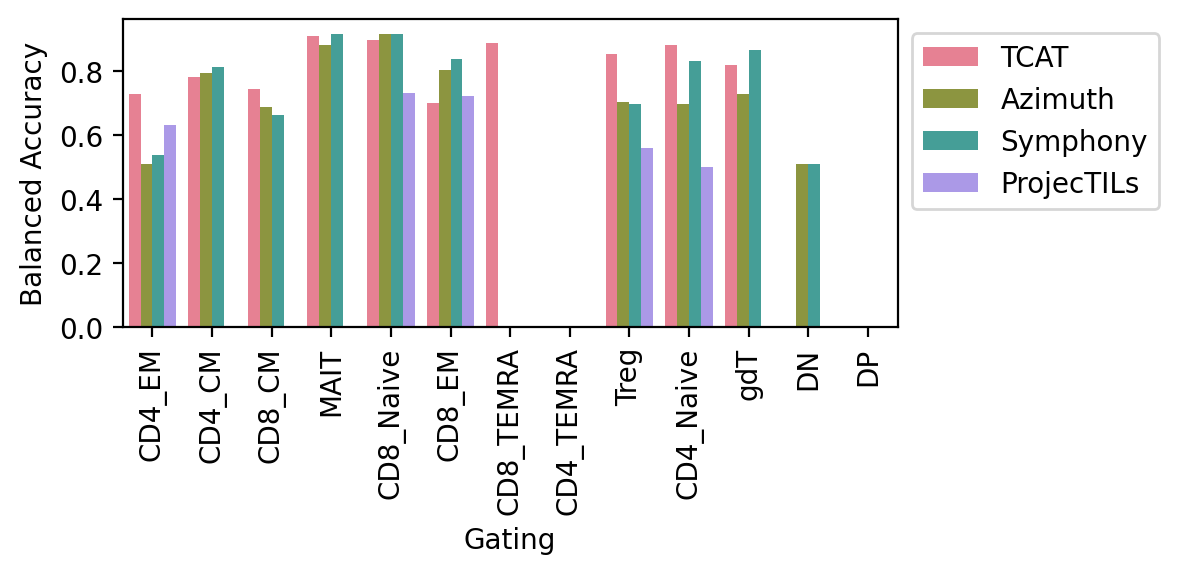

In [141]:
fig, ax = plt.subplots(dpi = 200, figsize = (5, 2))
sns.barplot(data=accuracy_plot, x='gate', y='value', hue='label', 
            order = col_order, #list([x.replace('_', ' ') for x in reversed(gate_order)]),
            ax = ax, palette = sns.color_palette("husl", 4))
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('Gating')
ax.set_ylabel('Balanced Accuracy')
ax.legend(title = '', bbox_to_anchor=(1, 1))

In [143]:
# Filter out gates that no models attempt ot predict
gates_filt = ['CD4_TEMRA', 'DP']
comp_all_filt = comp_all[-comp_all['Gating'].isin(gates_filt)]

accuracy_multi = pd.DataFrame(
    [metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['Multinomial_Label_PredRename']),
     metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['predicted.celltype.l2_PredRename']),
    metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['cell_type_pred_knn_PredRename']),
     metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['ProjecTILsAllT_functional.cluster_PredRename'])
    ],
index = ['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn', 'ProjecTILsAllT_functional.cluster'],
    columns = ['value'])
accuracy_multi['name']= accuracy_multi.index
accuracy_multi['label'] = accuracy_multi['name'].replace(acc_label_map)

/tmp/402154.tmpdir/ipykernel_286447/346188771.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


Text(0.5, 1.0, 'AIM-Seq')

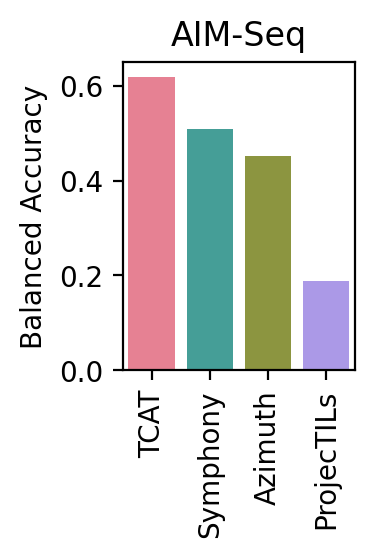

In [146]:
fig, ax = plt.subplots(dpi = 200, figsize = (1.5, 2))
sns.barplot(data=accuracy_multi, x='label', y='value', hue='label', 
            order = ['TCAT', 'Symphony', 'Azimuth', 'ProjecTILs'],
            ax = ax, palette = sns.color_palette("husl", 4))
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('')
ax.set_ylabel('Balanced Accuracy')
ax.set_title(dataset_name)
# ax.legend(title = '', bbox_to_anchor=(1, 1))

In [ ]:
# Non-balanced accuracy
accuracy_multi_reg = pd.DataFrame(
    [metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['Multinomial_Label_PredRename']),
     metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['predicted.celltype.l2_PredRename']),
    metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['cell_type_pred_knn_PredRename']),
     metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['ProjecTILsAllT_functional.cluster_PredRename'])
    ],
index = ['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn', 'ProjecTILsAllT_functional.cluster'],
    columns = ['value'])
accuracy_multi_reg['name']= accuracy_multi_reg.index
accuracy_multi_reg['label'] = accuracy_multi_reg['name'].replace(acc_label_map)

/tmp/402154.tmpdir/ipykernel_286447/3017429338.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


Text(0.5, 1.0, 'AIM-Seq')

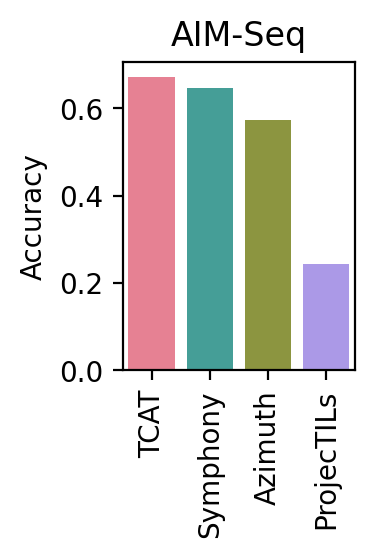

In [ ]:
fig, ax = plt.subplots(dpi = 200, figsize = (1.5, 2))
sns.barplot(data=accuracy_multi_reg, x='label', y='value', hue='label', 
            order = ['TCAT', 'Symphony', 'Azimuth', 'ProjecTILs'],
            ax = ax, palette = sns.color_palette("husl", 4))
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title(dataset_name)
# ax.legend(title = '', bbox_to_anchor=(1, 1))

In [148]:
accuracy_multi_all = pd.concat([accuracy_multi, accuracy_multi_reg], keys = ['Balanced Accuracy', 'Accuracy'])
accuracy_multi_all = accuracy_multi_all.reset_index(level = 0)
accuracy_multi_all = accuracy_multi_all.rename({'level_0' : 'type'}, axis = 1)

In [149]:
accuracy_multi_all

,type,value,name,label
Multinomial_Label,Balanced Accuracy,0.619259,Multinomial_Label,TCAT
predicted.celltype.l2,Balanced Accuracy,0.452898,predicted.celltype.l2,Azimuth
cell_type_pred_knn,Balanced Accuracy,0.508964,cell_type_pred_knn,Symphony
ProjecTILsAllT_functional.cluster,Balanced Accuracy,0.188733,ProjecTILsAllT_functional.cluster,ProjecTILs
Multinomial_Label,Accuracy,0.672560,Multinomial_Label,TCAT
predicted.celltype.l2,Accuracy,0.574193,predicted.celltype.l2,Azimuth
cell_type_pred_knn,Accuracy,0.646875,cell_type_pred_knn,Symphony
ProjecTILsAllT_functional.cluster,Accuracy,0.242063,ProjecTILsAllT_functional.cluster,ProjecTILs


/tmp/402154.tmpdir/ipykernel_286447/3814037564.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


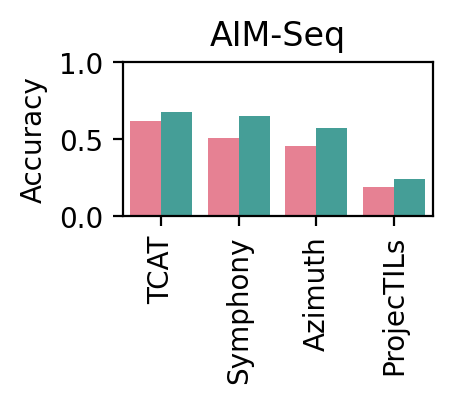

In [150]:
fig, ax = plt.subplots(dpi = 200, figsize = (2, 1))
sns.barplot(data=accuracy_multi_all, x='label', y='value', hue='type', 
            order = ['TCAT', 'Symphony', 'Azimuth', 'ProjecTILs'],
            ax = ax, palette = sns.color_palette("husl", 2),
           legend = None)
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title(dataset_name)
ax.set_ylim([0, 1])

plt.savefig(os.path.join(figdir, 'Revision_LineageAccuracy_Stimseq.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_LineageAccuracy_Stimseq.pdf'), bbox_inches="tight")
plt.show()

### benchmark AIM status

In [150]:
ind = comp_all[comp_all['Sort_Status'].isin(['+', '-'])].index

In [151]:
from sklearn.metrics import roc_curve, roc_auc_score

In [152]:
fprs = {}
tprs = {}
aucs = {}

# for c in ['ASA']+ list(gsetnames):
#     fpr, tpr, thresholds = roc_curve(comp_all.loc[ind, 'Sort_Status']=='+', comp_all.loc[ind, c])
#     auc = roc_auc_score(comp_all.loc[ind, 'Sort_Status']=='+', comp_all.loc[ind, c])
#     fprs[c], tprs[c], aucs[c] = fpr, tpr, auc

In [910]:
label_fontsize = 10

In [153]:
lineage_classes = ['CD4 Conv', 'CD4 Treg', 'CD8 Conv', 'Other']

In [154]:
for c in ['ASA']+ list(gsetnames):
    fprs[c], tprs[c], aucs[c] = {}, {}, {}
    
    for lineage in lineage_classes + ['All']:
        if lineage == 'All':
            overlap_lineage = ind
        else:
            overlap_lineage = comp_all.loc[ind, :][comp_all.loc[ind, 'Gating_Class']==lineage].index


        fpr, tpr, thresholds = roc_curve(comp_all.loc[overlap_lineage, 'Sort_Status']=='+', 
                                         comp_all.loc[overlap_lineage, c])
        auc = roc_auc_score(comp_all.loc[overlap_lineage, 'Sort_Status']=='+', 
                            comp_all.loc[overlap_lineage, c])
        fprs[c][lineage], tprs[c][lineage], aucs[c][lineage] = fpr, tpr, auc

In [130]:
pd.DataFrame([(k, v['All']) for k, v in aucs.items()]).sort_values(1)

,0,1
1,GOBP_ACTIVATED_T_CELL_PROLIFERATION,0.588173
3,GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,0.660007
4,GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TRE...,0.684536
5,GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.720879
6,GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TRE...,0.721267
9,WP_TCELL_ACTIVATION_SARSCOV2,0.744579
7,GSE15659_RESTING_VS_ACTIVATED_TREG_DN,0.753203
0,ASA,0.822704
8,GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,0.843704
2,GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,0.852313


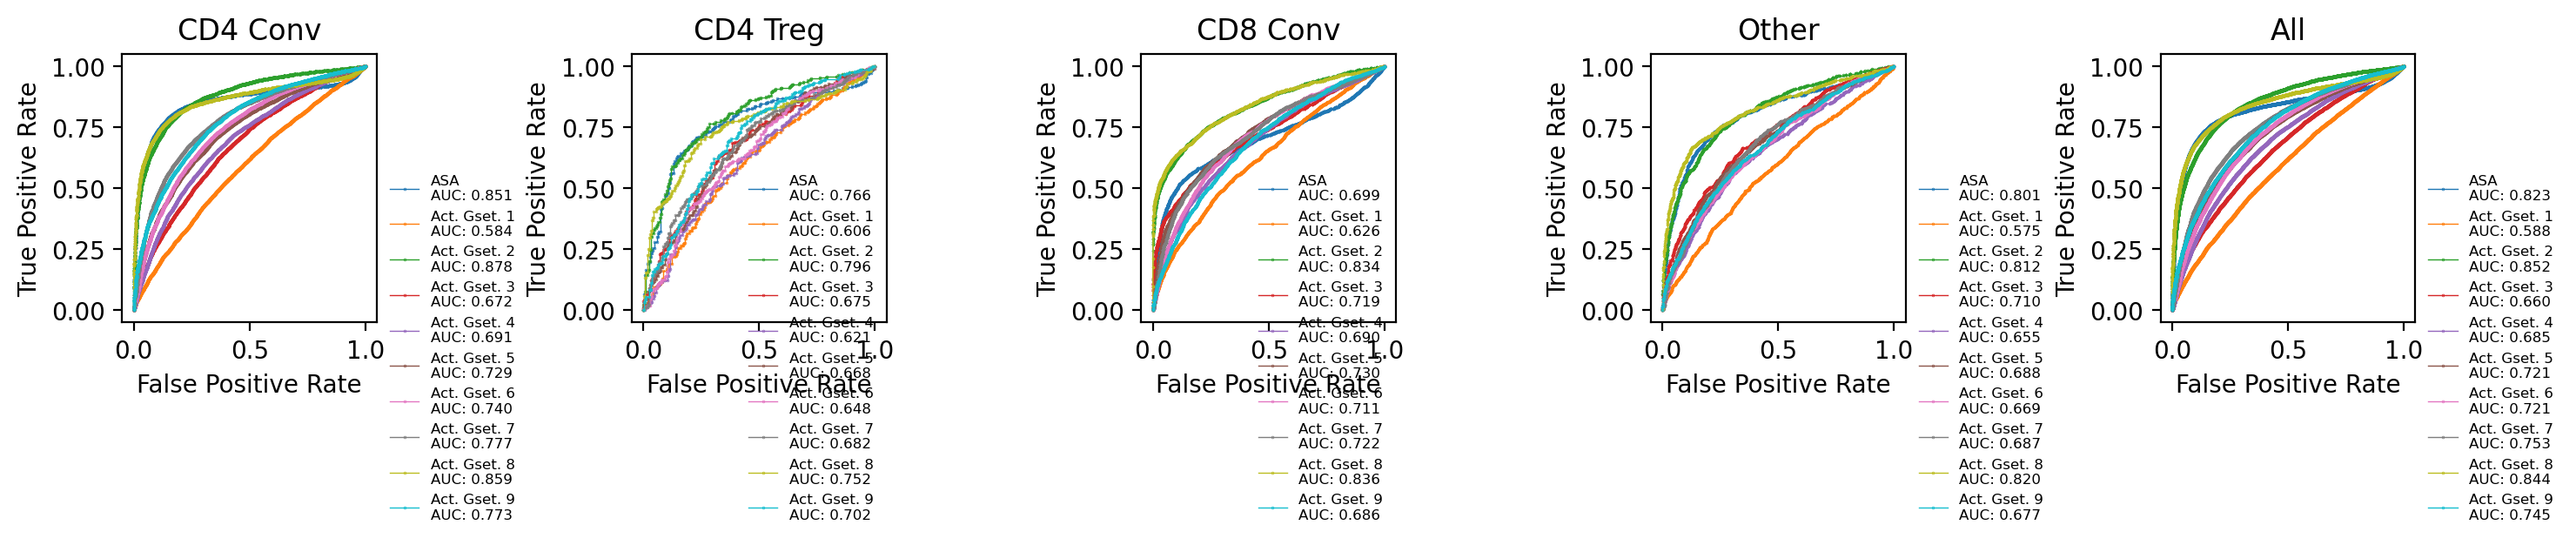

In [960]:
fig, axes = plt.subplots(dpi = 200, ncols = len(lineage_classes) + 1, figsize = (17, 2),
                        gridspec_kw = {'wspace' : 1})
for n, lineage in enumerate(lineage_classes + ['All']):

    ax = axes[n]

    for z, c in enumerate(['ASA']+ list(gsetnames)):
        # print(label)
        if c=='ASA':
            label = c
        else:
            label = 'Act. Gset. %i' % z
        fpr, tpr, auc = fprs[c][lineage], tprs[c][lineage], aucs[c][lineage]


        ax.set_xlabel('False Positive Rate', fontsize = label_fontsize)
        ax.set_ylabel('True Positive Rate', fontsize = label_fontsize)
        ax.plot(fpr, tpr, marker='.',# color = 'cornflowerblue', 
                 zorder = 3, linewidth = .5, ms = .5,
                 label = '%s\nAUC: %.3f' %(label, auc))#'%s AUC: %.3f' % (c, auc))

    # handles, labels = 
    # print(ax.get_legend_handles_labels())
    # ax.legend(handles[:4], labels[:4], fontsize=7, frameon=False, bbox_to_anchor=(1, 1))

    ax.legend(fontsize = 6, frameon=False, bbox_to_anchor = (1, .6))
    ax.set_title(lineage)

Text(0.5, 1.1, 'Stimseq')

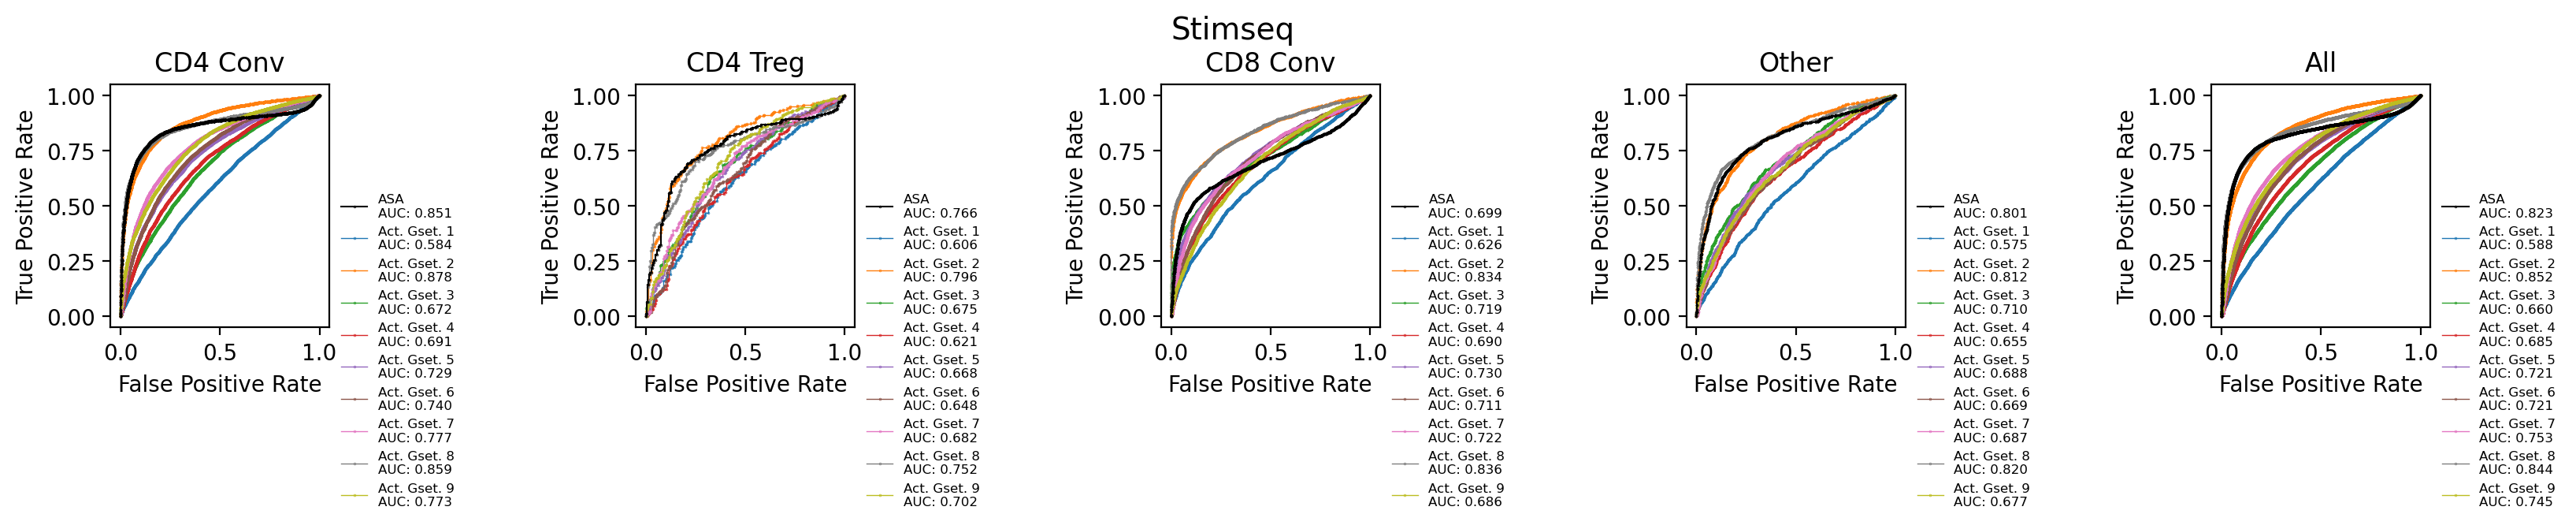

In [963]:
fig, axes = plt.subplots(dpi = 200, ncols = len(lineage_classes) + 1, figsize = (19, 2),
                        gridspec_kw = {'wspace' : 1.4})
for n, lineage in enumerate(lineage_classes + ['All']):

    ax = axes[n]

    for z, c in enumerate(['ASA']+ list(gsetnames)):
        # print(label)
        if c=='ASA':
            label = c
        else:
            label = 'Act. Gset. %i' % z
        fpr, tpr, auc = fprs[c][lineage], tprs[c][lineage], aucs[c][lineage]


        ax.set_xlabel('False Positive Rate', fontsize = label_fontsize)
        ax.set_ylabel('True Positive Rate', fontsize = label_fontsize)
        if c=='ASA':
            ax.plot(fpr, tpr, marker='.', color = 'black', 
                 zorder = 10, linewidth = .75, ms = .5,
                 label = '%s\nAUC: %.3f' %(label, auc))#'%s AUC: %.3f' % (c, auc))

        else:
            ax.plot(fpr, tpr, marker='.',# color = 'cornflowerblue', 
                     zorder = 3, linewidth = .5, ms = .5,
                     label = '%s\nAUC: %.3f' %(label, auc))#'%s AUC: %.3f' % (c, auc))

    # handles, labels = 
    # print(ax.get_legend_handles_labels())
    # ax.legend(handles[:4], labels[:4], fontsize=7, frameon=False, bbox_to_anchor=(1, 1))

    ax.legend(fontsize = 6, frameon=False, bbox_to_anchor = (1, .6))
    ax.set_title(lineage)
plt.suptitle(dataset, y = 1.1, fontsize = 14)

In [964]:
gsetnames_short = dict(zip(['ASA']+ list(gsetnames), ['ASA']+ list(gsetnames)))

In [155]:
gsetnames_short ={'ASA':'ASA',
    'GOBP_ACTIVATED_T_CELL_PROLIFERATION': 'GOBP_ACT',
 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN': 'GSE13738_RVT',
 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP': 'GSE13738_TVB',
 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_CVA',
 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_NAVA',
 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_NSVA',
 'GSE15659_RESTING_VS_ACTIVATED_TREG_DN': 'GSE15659_RVA',
 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN': 'GSE28726_NVA',
 'WP_TCELL_ACTIVATION_SARSCOV2': 'WP_ACTCOV'}


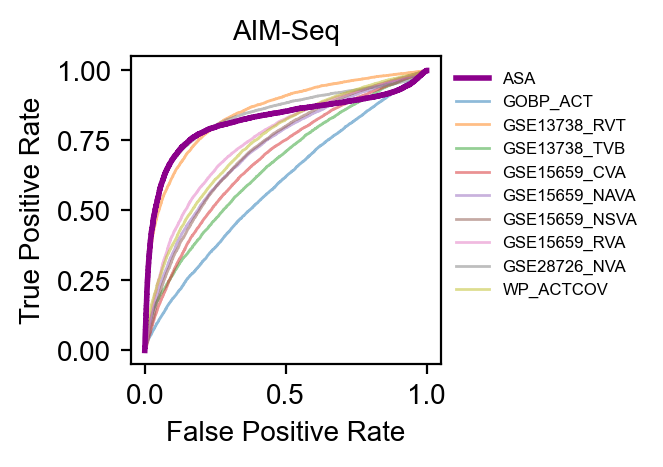

In [157]:
fig, ax = plt.subplots(dpi = 200, 
                       figsize = (2, 2),
                        gridspec_kw = {'wspace' : 1.8})
n = 0 
lineage = 'All'


for z, c in enumerate(['ASA']+ list(gsetnames)):
    # print(label)
    if c=='ASA':
        label = c
    else:
        label = gsetnames_short[c] #'%s.' % c[0:c[0:20].rfind('_')]
    fpr, tpr, auc = fprs[c][lineage], tprs[c][lineage], aucs[c][lineage]


    ax.set_xlabel('False Positive Rate', fontsize = label_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize = label_fontsize)
    if c=='ASA':
        ax.plot(fpr, tpr, color = 'darkmagenta', 
             zorder = 10, linewidth = 2,# ms = .5,
             label = '%s' %(label))#'%s AUC: %.3f' % (c, auc))

    else:
        ax.plot(fpr, tpr, #marker='.',# color = 'cornflowerblue', 
                 zorder = 3, linewidth = 1, alpha = 0.5,
                 label = '%s' %(label))#'%s AUC: %.3f' % (c, auc))

# handles, labels = 
# print(ax.get_legend_handles_labels())
# ax.legend(handles[:4], labels[:4], fontsize=7, frameon=False, bbox_to_anchor=(1, 1))

ax.legend(fontsize = 6, frameon=False, bbox_to_anchor = (1, 1))
ax.set_title(dataset_name, fontsize = label_fontsize)

plt.savefig(os.path.join(figdir, 'Revision_ActivationROC_Stimseq.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_ActivationROC_Stimseq.pdf'), bbox_inches="tight")
plt.show()

In [158]:
gset_cmap = dict(zip(gsetnames,
                    ['silver']*len(gsetnames)))
gset_cmap['ASA'] = 'dimgrey'

In [159]:
aucs_df = pd.DataFrame.from_dict(aucs)
aucs_plot = pd.DataFrame(aucs_df.loc['All', :].sort_values(ascending = False))
aucs_plot['label'] = aucs_plot.index.map(gsetnames_short)

In [160]:
aucs_plot

,All,label
GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,0.852313,GSE13738_RVT
GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,0.843704,GSE28726_NVA
ASA,0.822704,ASA
GSE15659_RESTING_VS_ACTIVATED_TREG_DN,0.753203,GSE15659_RVA
WP_TCELL_ACTIVATION_SARSCOV2,0.744579,WP_ACTCOV
GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN,0.721267,GSE15659_NSVA
GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.720879,GSE15659_NAVA
GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.684536,GSE15659_CVA
GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,0.660007,GSE13738_TVB
GOBP_ACTIVATED_T_CELL_PROLIFERATION,0.588173,GOBP_ACT


In [161]:
[gset_cmap[x] for x in aucs_plot.index]

['silver',
 'silver',
 'dimgrey',
 'silver',
 'silver',
 'silver',
 'silver',
 'silver',
 'silver',
 'silver']

/tmp/ipykernel_222298/3403137241.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


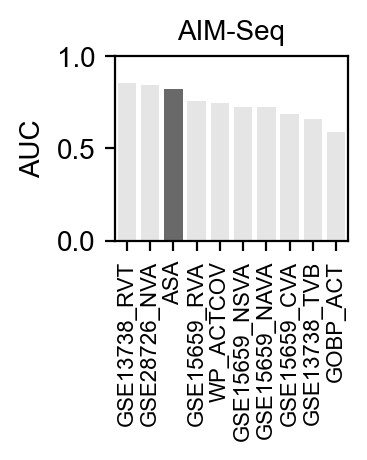

In [165]:
fig, ax = plt.subplots(dpi = 200, figsize = (1.5, 1.2))
sns.barplot(data=aucs_plot, x='label', y='All', hue='label', 
            # order = aims,
            ax = ax, palette = [gset_cmap[x] for x in aucs_plot.index], 
            alpha = 0.4,
           )
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation =  90, fontsize = tick_fontsize, 
                   # rotation_mode="anchor", ha = 'right'
                  )
ax.set_xlabel('')
ax.set_ylabel('AUC')
ax.set_ylim([0, 1])
ax.set_title(dataset_name, fontsize = label_fontsize)
# ax.containers[0].set_alpha(1)

ax.containers[2][0].set_alpha(1)

plt.savefig(os.path.join(figdir, 'Revision_ActivationAUCs_Stimseq.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_ActivationAUCs_Stimseq.pdf'), bbox_inches="tight")
plt.show()

# Sparks

In [82]:
dataset = 'Sparks'
dataset_name = 'Flu-Vaccine'

In [7]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

cgep_info = read_dataset_log('cGEP_Name')
name_map = dict(zip(cgep_info['cGep_Name'], cgep_info['Short_Name']))

In [8]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
lineage_gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t')['0']
lineage_gating = lineage_gating.rename('Gating')
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')

usage.columns = usage.columns.map(name_map)

/tmp/ipykernel_222298/903360486.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')


In [135]:
params.loc[dataset, 'tcat_fn']

'/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.20231016.FiltSingletons.Rescaled.Sparks.tsv'

In [136]:
display(usage.head(2))
display(lineage_gating.head(2))
display(meta.head(2))

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,0.000849,0.066426,0.001936,0.002624,0.046895,0.000561,0.006672,0.001460,0.007250,0.002262,...,0.005393,0.003929,0.017760,0.064005,0.002354,0.009155,0.016708,0.001454,0.000970,0.007313
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,0.000636,0.046621,0.007689,0.005236,0.004762,0.001081,0.001814,0.008122,0.001867,0.001442,...,0.006249,0.001177,0.025001,0.038214,0.014621,0.010667,0.116343,0.002023,0.003218,0.005206


Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1    CD4_Naive
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1       CD4_CM
Name: Gating, dtype: object

,alt.subject.id,visit,covid.diagnosis.start.date.to.sample.drawn,group,sex,age,race,ethnicity,flu.vax.count.10yr,vaccine,...,leiden_res0_6,leiden_res2_25,leiden_res2,leiden_res1_75,leiden_res1_5,leiden_res1_25,leiden_res0_75,leiden_res0_5,leiden_res0_25,alt.sample.id
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,5,5,5,4,0,0,0,0,Control
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,1,1,1,2,4,1,1,Control


In [7]:
cat = starCAT(reference='TCAT.V1', cachedir='../../Data/Misc/cache')

Using reference from starCAT database
Loading reference from existing cache file for reference TCAT.V1


In [8]:
cat.usage = usage
cat.usage_norm = usage.div(usage.sum(axis=1), axis=0).copy()
scores = cat.compute_addon_scores()

/PHShome/mc1070/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
# scores.to_csv('../../Data/PerDataset/Sparks2023/TCAT_scores.20231016.tsv')

In [9]:
scores = pd.read_csv('../../Data/PerDataset/Sparks2023/TCAT_scores.20231016.tsv', index_col = 0, 
                    sep = ',')

In [10]:
gating_act = pd.read_csv(params.loc[dataset, 'manual_activation_gating_fn'],
                         index_col = 0, sep = '\t')


In [32]:
gating_act['Activated']

Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1    Unactivated
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1    Unactivated
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1    Unactivated
Batch1_COVFLU_CITE_multi5P03_AGGGTGACATTAGGCT-1    Unactivated
Batch1_COVFLU_CITE_multi5P10_GAACCTACAACGCACC-1    Unactivated
                                                      ...     
Batch3_COVFLU_CITE_multi5P16_TTCGAAGGTCTCTTTA-1    Unactivated
Batch3_COVFLU_CITE_multi5P09_CTCGTACGTAGGACAC-1    Unactivated
Batch3_COVFLU_CITE_multi5P09_ACGGCCACAAGAAGAG-1    Unactivated
Batch3_COVFLU_CITE_multi5P07_GAGTCCGCACACAGAG-1    Unactivated
Batch3_COVFLU_CITE_multi5P09_AAGGCAGTCGCGTTTC-1    Unactivated
Name: Activated, Length: 336739, dtype: object

In [12]:
len(gsetnames)

18

In [11]:
from functools import reduce

In [12]:
lineage_gating_class = pd.Series(np.nan, index = lineage_gating.index)
lineage_gating_class.loc[lineage_gating.str.contains('CD4')] = 'CD4 Conv'
lineage_gating_class.loc[lineage_gating=='Treg'] = 'CD4 Treg'
lineage_gating_class.loc[lineage_gating.str.contains('CD8')] = 'CD8 Conv'
lineage_gating_class.loc[lineage_gating_class.isna()] = 'Other'
lineage_gating_class.name = 'Gating_Class'

/tmp/ipykernel_222298/1899751058.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CD4 Conv' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  lineage_gating_class.loc[lineage_gating.str.contains('CD4')] = 'CD4 Conv'


## compute gene set activation scores

In [11]:
import re

In [30]:
gsets = gp.parser.read_gmt('../../Data/Misc/activationgenesets.v2024.1.Hs_3000.gmt')

include_terms = r'ACTIVA'
include_terms2= r'CD8_TCELL|CD8|CD4_TCELL|CD4|TREG|TH17|TH1|TH2|TFH|TCELL|T_CELL'
exclude_terms = r'BCELL|MYELOID|THYMOCYTE|INNATE_LYMPHOID_CELL|POS_DC|WEAK_DC|CD40|PBMC_VS_MEM_CD4_TCELL|HEMATOPOIETIC_STEM_CELL|LYMPHOID_PRIMED_MPP|BASOPHIL|_DC_VS_|EOSINOPHI|MAC_VS|MAST_CELL|NEUTROPHIL|NKCELL|PROGENITOR|LSK|LIN_NEG_VS|NKTCELL|ERYTHTROBLAST|MONO_MAC|NKT|NK_T_CELL'

In [31]:
gsetnames_filt = [
    gs for gs in gsets.keys()
    if re.search(include_terms, gs) and re.search(include_terms2, gs) and not re.search(exclude_terms, gs)
]

In [32]:
len(gsetnames_filt)

37

In [34]:
gsetnames_filt = ['GOBP_ACTIVATED_T_CELL_PROLIFERATION',
 # 'GOBP_ACTIVATION_INDUCED_CELL_DEATH_OF_T_CELLS',
 # 'GOBP_NEGATIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION',
 # 'GOBP_NEGATIVE_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_NEGATIVE_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_NEGATIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION',
 # 'GOBP_POSITIVE_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_POSITIVE_REGULATION_OF_GAMMA_DELTA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_GAMMA_DELTA_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_T_CELL_ACTIVATION',
 # 'GOBP_REGULATION_OF_T_CELL_ACTIVATION_VIA_T_CELL_RECEPTOR_CONTACT_WITH_ANTIGEN_BOUND_TO_MHC_MOLECULE_ON_ANTIGEN_PRESENTING_CELL',
 # 'GSE13738_RESTING_VS_BYSTANDER_ACTIVATED_CD4_TCELL_DN',
 # 'GSE13738_RESTING_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
 # 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_UP',
 # 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_DN',
 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_UP',
 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_UP',
 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_UP',
 'GSE15659_RESTING_VS_ACTIVATED_TREG_DN',
 # 'GSE15659_RESTING_VS_ACTIVATED_TREG_UP',
 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN',
 # 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_UP',
 # 'HP_ABNORMAL_T_CELL_ACTIVATION',
 # 'POSITIVE_REGULATION_OF_T_CELL_ACTIVATION',
 # 'WP_MODULATORS_OF_TCR_SIGNALING_AND_T_CELL_ACTIVATION',
 'WP_TCELL_ACTIVATION_SARSCOV2']


# ['GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
#                   'GOBP_ACTIVATED_T_CELL_PROLIFERATION',
#                   'WP_TCELL_ACTIVATION_SARSCOV2'
# ]

In [15]:
adata = sc.read(params.loc[dataset, 'raw_counts_filt_fn'])
# adata.var.index  = adata.var['gene_name'].astype('str')
# adata.var_names_make_unique()

In [24]:
adata = adata[:, adata.var['feature_types']=='Gene Expression']

In [25]:
adata.var_names_make_unique()

In [26]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [35]:
gsetnames_filt

['GOBP_ACTIVATED_T_CELL_PROLIFERATION',
 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN',
 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN',
 'GSE15659_RESTING_VS_ACTIVATED_TREG_DN',
 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN',
 'WP_TCELL_ACTIVATION_SARSCOV2']

In [36]:
gset_size = 20

In [37]:
for gs in gsetnames_filt:
    print(len(gsets[gs]))
    sc.tl.score_genes(adata, gsets[gs], score_name = gs, random_state = 0)
    
    g_overlap = adata.var.index.intersection(gsets[gs])
    adata.obs[f'{gs}_Mean'] = adata[:, g_overlap].X.mean(axis = 1)

49
200
       'DMAC1', 'GSDME', 'KYAT3', 'MEAK7', 'PTGR3', 'SELENOS', 'SPACA9',
       'YARS1'],
      dtype='object')
198
       'LINC01281', 'LINC01588', 'NEMP2', 'PXYLP1', 'RUBCNL', 'STK26', 'STMP1',
       'TENT4B'],
      dtype='object')
198
       'NECTIN4', 'PLPP5', 'POLR1H', 'ROS1', 'SEPTIN3', 'SGO2', 'SHISA6',
       'SLC35E2A', 'SNORA65', 'SOX2-OT', 'STING1', 'SYN2', 'TCP10L3', 'TFF2',
       'TRIML1', 'TTTY13', 'UBE2U', 'UTP11', 'WARS1', 'ZAN', 'ZDHHC8BP',
       'ZNF316', 'ZNF663P'],
      dtype='object')
198
       'POLR1H', 'PRAMEF12', 'ROS1', 'SCEL', 'SEPTIN3', 'SGO2', 'SHISA6',
       'SNORA65', 'SOX2-OT', 'STING1', 'SYN2', 'TCP10L3', 'TFF2', 'TMCO5A',
       'TRIML1', 'UBE2U', 'WARS1', 'ZAN', 'ZNF861P'],
      dtype='object')
197
       'ROS1', 'SEPTIN3', 'SGO2', 'SHISA6', 'SOX2-OT', 'SPACA7', 'SYN2',
       'TCP10L3', 'TFF2', 'TRIML1', 'UBE2U', 'UTP11', 'ZAN', 'ZDHHC8BP',
       'ZNF861P'],
      dtype='object')
198
       'LMNTD2-AS1', 'NECTIN4', 'POLR1H', 'ROS1', 'S

In [39]:
adata.obs[gsetnames_filt + [f'{gs}_Mean' for gs in gsetnames_filt]].to_csv('../../Data/PerDataset/Sparks2023/gene_scores_activation.tsv', sep = '\t')

## compare to Azimuth, ProjectTILs, symphony, etc.

In [13]:
az_fn = '../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.Azimuth.tsv'
az_res = pd.read_csv(az_fn, index_col = 0, sep = '\t')
az_res = az_res[az_res.columns[az_res.columns.str.contains('predicted.celltype')]]

/tmp/ipykernel_222298/3928515869.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  az_res = pd.read_csv(az_fn, index_col = 0, sep = '\t')


In [276]:
az_res.head(3)

,predicted.celltype.l1.score,predicted.celltype.l1,predicted.celltype.l2.score,predicted.celltype.l2,predicted.celltype.l3.score,predicted.celltype.l3
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,0.927758,CD4 T,0.910735,CD4 TCM,0.906060,CD4 TCM_1
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,0.986412,CD4 T,0.986412,CD4 TCM,0.986412,CD4 TCM_1
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,1.000000,CD4 T,1.000000,CD4 TCM,0.974350,CD4 TCM_1


In [14]:
sym_fn = '../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.symphony.tsv'
sym_res = pd.read_csv(sym_fn, index_col = 0, sep = '\t')


In [278]:
sym_res.head(3)

,cell_type_pred_knn,cell_type_pred_knn_prob
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,CD4 Naive,0.6
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,CD4 TCM,1.0
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,CD4 TCM,1.0


In [15]:
# ptils_cd4_fn = '../../Data/PerDataset/Sparks2023/raw.mincellfilt.htonegfilt.doubletfilt.ProjectTILsCD4.tsv'
# ptils_cd4 = pd.read_csv(ptils_cd4_fn, index_col = 0, sep = '\t')
# ptils_cd4.columns = 'ProjecTILsCD4_' + ptils_cd4.columns

# ptils_cd8_fn = '../../Data/PerDataset/Sparks2023/raw.mincellfilt.htonegfilt.doubletfilt.ProjectTILsCD8.tsv'
# ptils_cd8 = pd.read_csv(ptils_cd8_fn, index_col = 0, sep = '\t')
# ptils_cd8.columns = 'ProjecTILsCD8_' + ptils_cd8.columns

ptils_allt_fn = '../../Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.ProjectTILsAllTMouse.tsv'
ptils_allt = pd.read_csv(ptils_allt_fn, index_col = 0, sep = '\t')
ptils_allt.columns = 'ProjecTILsAllT_' + ptils_allt.columns

In [280]:
ptils_allt.head(2)

,ProjecTILsAllT_functional.cluster,ProjecTILsAllT_functional.cluster.conf
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,CD8_NaiveLike,1.000000
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,CD8_NaiveLike,0.956045


In [16]:
act_gsets_fn = '../../Data/PerDataset/Sparks2023/gene_scores_activation.tsv'
act_gsets = pd.read_csv(act_gsets_fn, index_col = 0, sep = '\t')
gsetnames = act_gsets.columns[~(act_gsets.columns.str.endswith('_Mean'))]
act_gsets = act_gsets[gsetnames]

In [16]:
gsetnames

Index(['GOBP_ACTIVATED_T_CELL_PROLIFERATION',
       'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN',
       'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP',
       'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN',
       'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN',
       'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN',
       'GSE15659_RESTING_VS_ACTIVATED_TREG_DN',
       'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN',
       'WP_TCELL_ACTIVATION_SARSCOV2'],
      dtype='object')

In [17]:
## Figure out why missing metadata later
az_res.shape, sym_res.shape, meta.shape, scores.shape

((335906, 6), (335906, 2), (336739, 42), (336739, 5))

In [18]:
from functools import reduce

In [19]:
# comp_all = reduce(lambda l, r: pd.merge(l, r, left_index = True, right_index = True, how='inner'), 
#                   [meta[meta['Sort_Status'].isin(['+', '-'])], scores, az_res, sym_res, ptils_cd4, ptils_cd8, ptils_allt,
#                    lineage_gating])
comp_all = reduce(lambda l, r: pd.merge(l, r, left_index = True, right_index = True, how='inner'), 
                  [meta, scores, az_res, sym_res,# ptils_cd4, ptils_cd8, 
                   ptils_allt,
                   lineage_gating, lineage_gating_class, gating_act[['Activated']], act_gsets])

In [20]:
comp_all.shape

(335906, 69)

In [20]:
comp_all['predicted.celltype.l2_renamed'] = 'Azimuth_' + comp_all['predicted.celltype.l2']
comp_all['Multinomial_Label_renamed'] = 'TCATMultiPred_' + comp_all['Multinomial_Label']
comp_all['cell_type_pred_knn_renamed'] = 'Symphony_' + comp_all['cell_type_pred_knn']

In [21]:
# comp_all['ProjecTILsCD8_functional.cluster_renamed'] = 'ProjecTILsCD8_' + comp_all['ProjecTILsCD8_functional.cluster']
# comp_all['ProjecTILsCD4_functional.cluster_renamed'] = 'ProjecTILsCD4_' + comp_all['ProjecTILsCD4_functional.cluster']
comp_all['ProjecTILsAllT_functional.cluster_renamed'] = 'ProjecTILsAllT_' + comp_all['ProjecTILsAllT_functional.cluster']


In [22]:
comp_all['ASA_binary_renamed'] = ''
comp_all.loc[comp_all['ASA_binary']==True, 'ASA_binary_renamed'] = 'ASA+'
comp_all.loc[comp_all['ASA_binary']==False, 'ASA_binary_renamed'] = 'ASA-'

In [23]:
comp[dataset] = comp_all

In [24]:
comp_all = comp[dataset]

### benchmark lineage across all cells

In [25]:
for col in ['Multinomial_Label_renamed', 'predicted.celltype.l2_renamed', 'cell_type_pred_knn_renamed',
           # 'ProjecTILsCD8_functional.cluster_renamed', 'ProjecTILsCD4_functional.cluster_renamed',
           'ProjecTILsAllT_functional.cluster_renamed']:
    comp_all[col] = pd.Categorical(comp_all[col])

In [26]:
ctbs = [pd.crosstab([comp_all['Multinomial_Label_renamed']], 
                [comp_all['Gating']], dropna=False),
     pd.crosstab(comp_all['predicted.celltype.l2_renamed'], 
                [ comp_all['Gating']], dropna=False),
     pd.crosstab(comp_all['cell_type_pred_knn_renamed'], 
                [ comp_all['Gating']], dropna=False),
     # pd.crosstab(comp_all['ProjecTILsCD8_functional.cluster_renamed'], 
     #            [ comp_all['Gating']], dropna=False),
     # pd.crosstab(comp_all['ProjecTILsCD4_functional.cluster_renamed'], 
     #            [ comp_all['Gating']], dropna=False),
     pd.crosstab(comp_all['ProjecTILsAllT_functional.cluster_renamed'], 
                [ comp_all['Gating']], dropna=False),
   ]

In [27]:
ncells_comp = pd.DataFrame()
ncells_comp_norm = pd.DataFrame()
odds_comp = pd.DataFrame()
p_comp = pd.DataFrame()

In [28]:
for ctb in ctbs:
    ncells_comp = pd.concat([ncells_comp, ctb], axis = 0)
    ncells_comp_norm = pd.concat([ncells_comp_norm, ctb.div(ctb.sum(), axis = 1)], axis = 0)

In [29]:
odds_comp = pd.DataFrame()
p_comp = pd.DataFrame()
for ctb in ctbs:
    odds_dat = pd.DataFrame(1, index = ctb.index, columns = ctb.columns)
    p_dat = pd.DataFrame(1, index = ctb.index, columns = ctb.columns)

    for gate in ctb.columns:
        for label in ctb.index:

            a = ctb.loc[label, gate]
            b = ctb.loc[:, gate].drop(label).sum()
            c = ctb.loc[label, :].drop(gate).sum()
            d = ctb.drop(label).drop(gate, axis = 1).sum().sum()

            odds_ratio, p = fisher_exact(np.array([a, b, c, d]).reshape(2, 2))
            odds_dat.loc[label, gate] = odds_ratio
            p_dat.loc[label, gate] = p
            
    odds_comp = pd.concat([odds_comp, odds_dat], axis = 0)
    p_comp = pd.concat([p_comp, p_dat], axis = 0)

/tmp/ipykernel_222298/1538203801.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.932347970946108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  odds_dat.loc[label, gate] = odds_ratio
/tmp/ipykernel_222298/1538203801.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7372040545134822e-175' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p_dat.loc[label, gate] = p
/tmp/ipykernel_222298/1538203801.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7673455109652427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  odds_dat.loc[label, gate] = odds_ratio
/tmp/ipykernel_222298/1538203801.py:17: FutureWarning: S

In [32]:
label_fontsize = 20
tick_fontsize = 16

Text(0.5, 160.4444444444444, 'Gating')

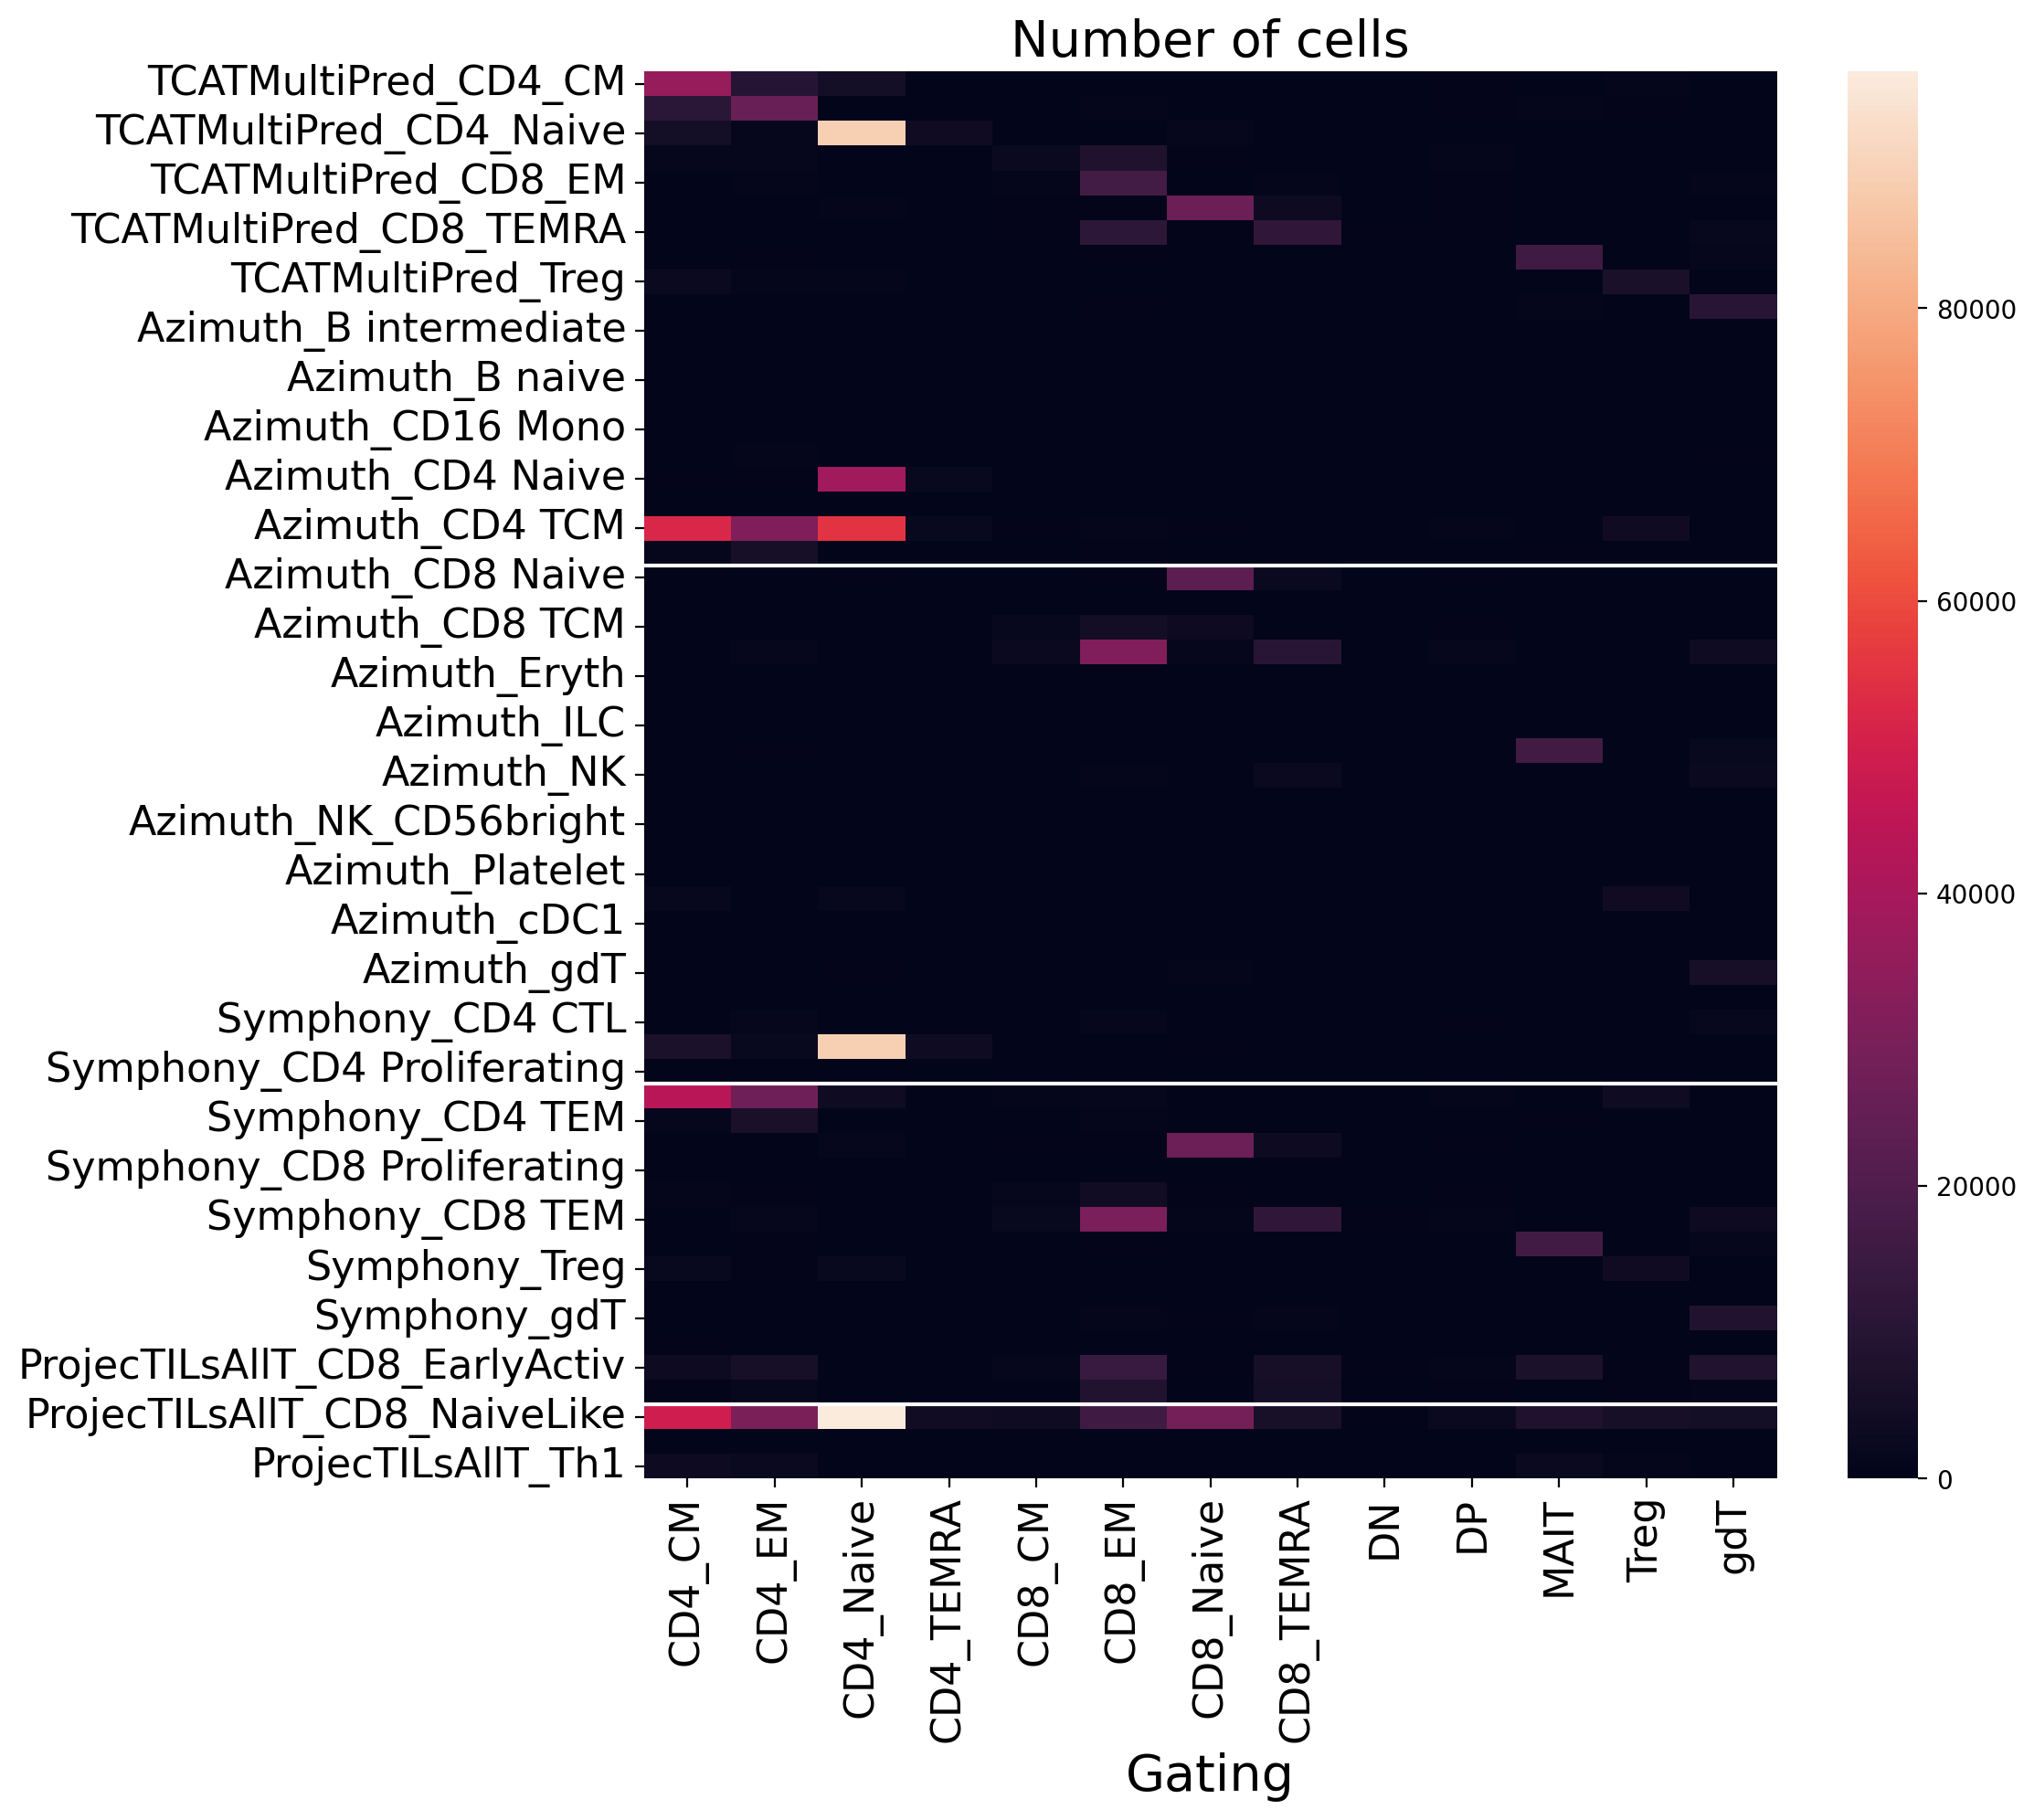

In [114]:
fig, ax = plt.subplots(dpi = 200, figsize = (10, 10))

sns.heatmap(ncells_comp, ax = ax)
ax.hlines(y = 20, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 41, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 54, xmin = 0, xmax = 40, color = 'white')
ax.set_title('Number of cells', fontsize = label_fontsize)
ax.tick_params('both', labelsize = tick_fontsize)
ax.set_xlabel(ax.get_xlabel(), fontsize = label_fontsize)

In [30]:
row_order = ['TCATMultiPred_CD4_EM',
 'TCATMultiPred_CD4_CM',
 'TCATMultiPred_CD8_CM',
 'TCATMultiPred_MAIT',
 'TCATMultiPred_CD8_Naive',
 'TCATMultiPred_CD8_EM',
 'TCATMultiPred_CD8_TEMRA',
 'TCATMultiPred_Treg',
 'TCATMultiPred_CD4_Naive',
 'TCATMultiPred_gdT',
]
#list(comp_all['Multinomial_Label_renamed'].unique())  #[[(l, 'ASA+'), (l, 'ASA-')] for l in comp_all['Multinomial_Label_renamed'].unique()]
#row_order = [item for sublist in row_order for item in sublist]

In [31]:
a_order = ['Azimuth_CD4 TEM', 'Azimuth_CD4 TCM', 'Azimuth_CD4 CTL', 'Azimuth_CD8 TCM',
                         'Azimuth_MAIT', 'Azimuth_CD8 Naive', 'Azimuth_CD8 TEM',
                         'Azimuth_Treg', 'Azimuth_CD4 Naive', 'Azimuth_gdT', 'Azimuth_dnT',
                         'Azimuth_CD4 Proliferating', 'Azimuth_CD8 Proliferating',
                    'Azimuth_ILC', 'Azimuth_NK', 'Azimuth_NK Proliferating',
                         'Azimuth_CD16 Mono', 'Azimuth_B naive', 'Azimuth_B intermediate',
                        'Azimuth_Eryth', 'Azimuth_Plasmablast']

In [32]:
s_order = [a.replace('Azimuth', 'Symphony') for a in a_order if a.replace('Azimuth', 'Symphony') in 
           comp_all['cell_type_pred_knn_renamed'].unique()]

In [33]:
p_order = ['ProjecTILsAllT_Th1', 
           # 'ProjecTILsAllT_Tfh',
        'ProjecTILsAllT_CD8_EarlyActiv',
       'ProjecTILsAllT_CD8_EffectorMemory', 
       'ProjecTILsAllT_CD8_Tex',
       # 'ProjecTILsAllT_CD8_Tpex',
        'ProjecTILsAllT_CD8_NaiveLike', 
        # 'ProjecTILsAllT_Treg',
        'ProjecTILsAllT_CD4_NaiveLike',
          ]

In [1014]:
set(comp_all['ProjecTILsAllT_functional.cluster_renamed'].unique()).difference(p_order)

set()

In [1015]:
set(p_order).difference(comp_all['ProjecTILsAllT_functional.cluster_renamed'].unique())

set()

In [34]:
row_order = row_order + a_order + s_order + p_order

In [35]:
col_order = ['CD4_EM',
 'CD4_CM',
 'CD8_CM',
 'MAIT',
 'CD8_Naive',
 'CD8_EM',
 'CD8_TEMRA',
 'CD4_TEMRA',
 'Treg',
 'CD4_Naive',
 'gdT',
 'DN',
 'DP']


In [36]:
label_fontsize = 10
tick_fontsize = 8

In [45]:
row_order_renamed = [l.replace('TCATMultiPred_', '').replace('Azimuth_', '').replace('Symphony_', '').replace('ProjecTILsAllT_', '').replace('_', ' ') 
 for l in row_order]

In [38]:
col_order_renamed = [c.replace('_', ' ') for c in col_order]

In [39]:
vmax = np.quantile(ncells_comp.unstack(), 0.99)
vmin = 0

Text(0.5, 1.0, 'Number of cells')

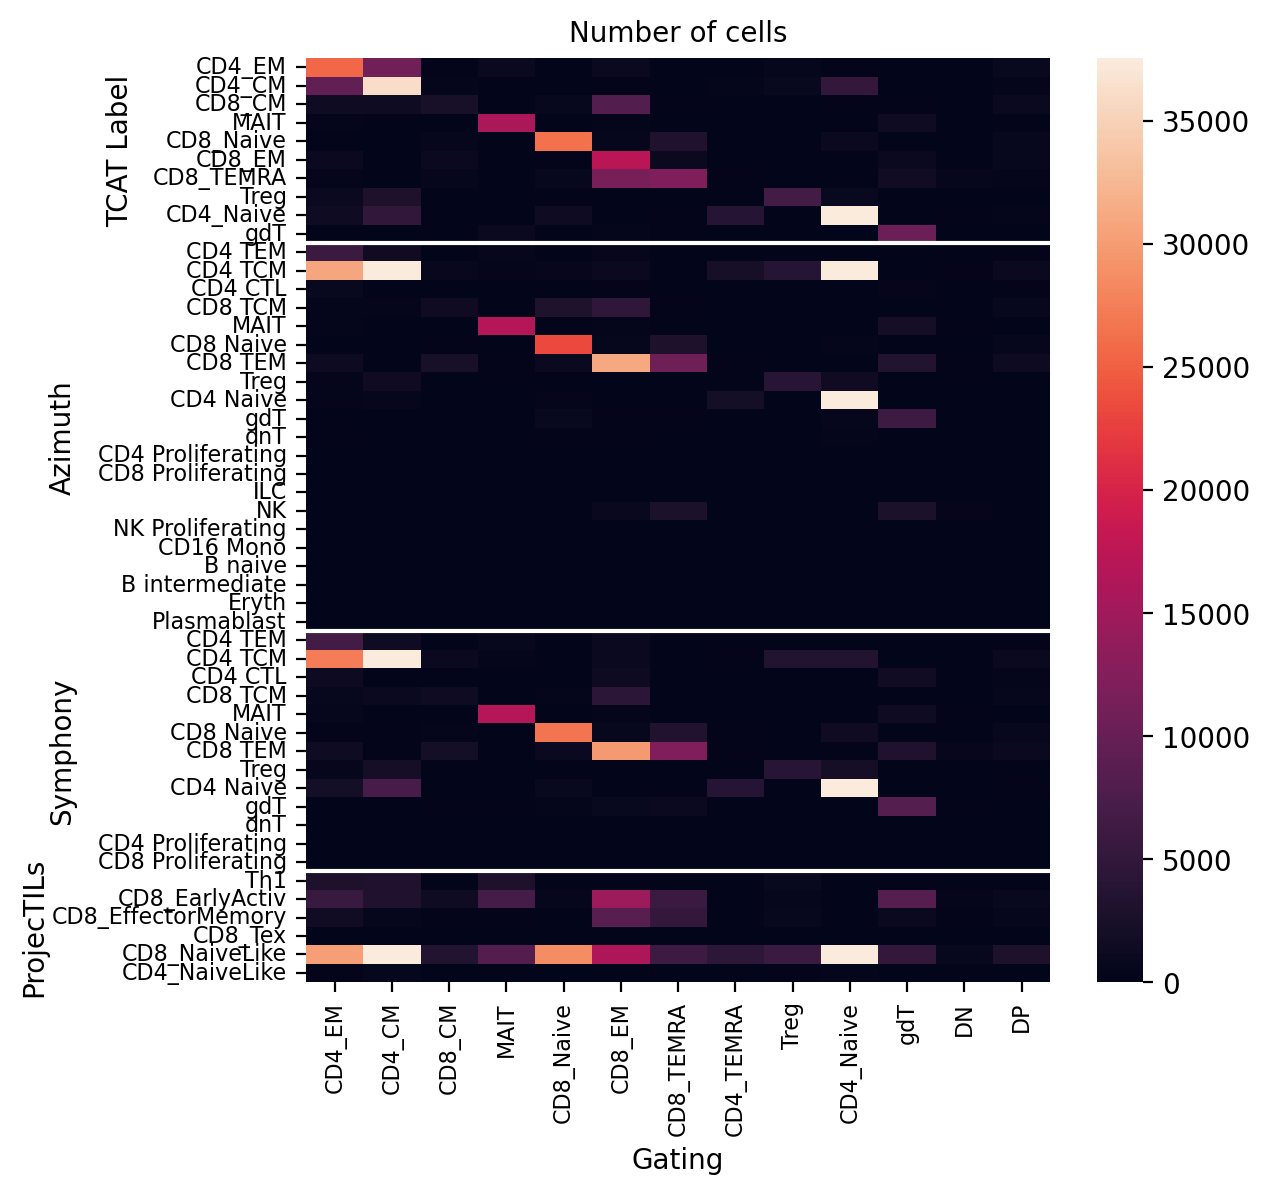

In [131]:
fig, ax = plt.subplots(dpi = 200, figsize = (6, 6), 
                      )

cbar =True 
sns.heatmap(ncells_comp.loc[row_order, col_order], cbar = cbar, 
            ax = ax, vmax = vmax, vmin = vmin)
ax.hlines(y = 10, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 31, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 44, xmin = 0, xmax = 40, color = 'white')
ax.text(-3.5, 5, 'TCAT Label', rotation = 90, va = 'center')
ax.text(-4.5, (31-10)/2 +10, 'Azimuth', rotation = 90, va = 'center')
ax.text(-4.5, (44-31)/2 +31, 'Symphony', rotation = 90, va = 'center')
ax.text(-5, (len(row_order)-44)/2 +44, 'ProjecTILs', rotation = 90, va = 'center')

ax.tick_params('both', labelsize = tick_fontsize)
ax.set_xlabel(ax.get_xlabel(), fontsize = label_fontsize)

ax.set_yticks(np.arange(0.5, 0.5+len(row_order_renamed)), row_order_renamed)
ax.set_title('Number of cells',  fontsize = label_fontsize)

In [55]:
vmax = 1#np.quantile(ncells_comp_norm.unstack(), 0.99)
vmin = 0

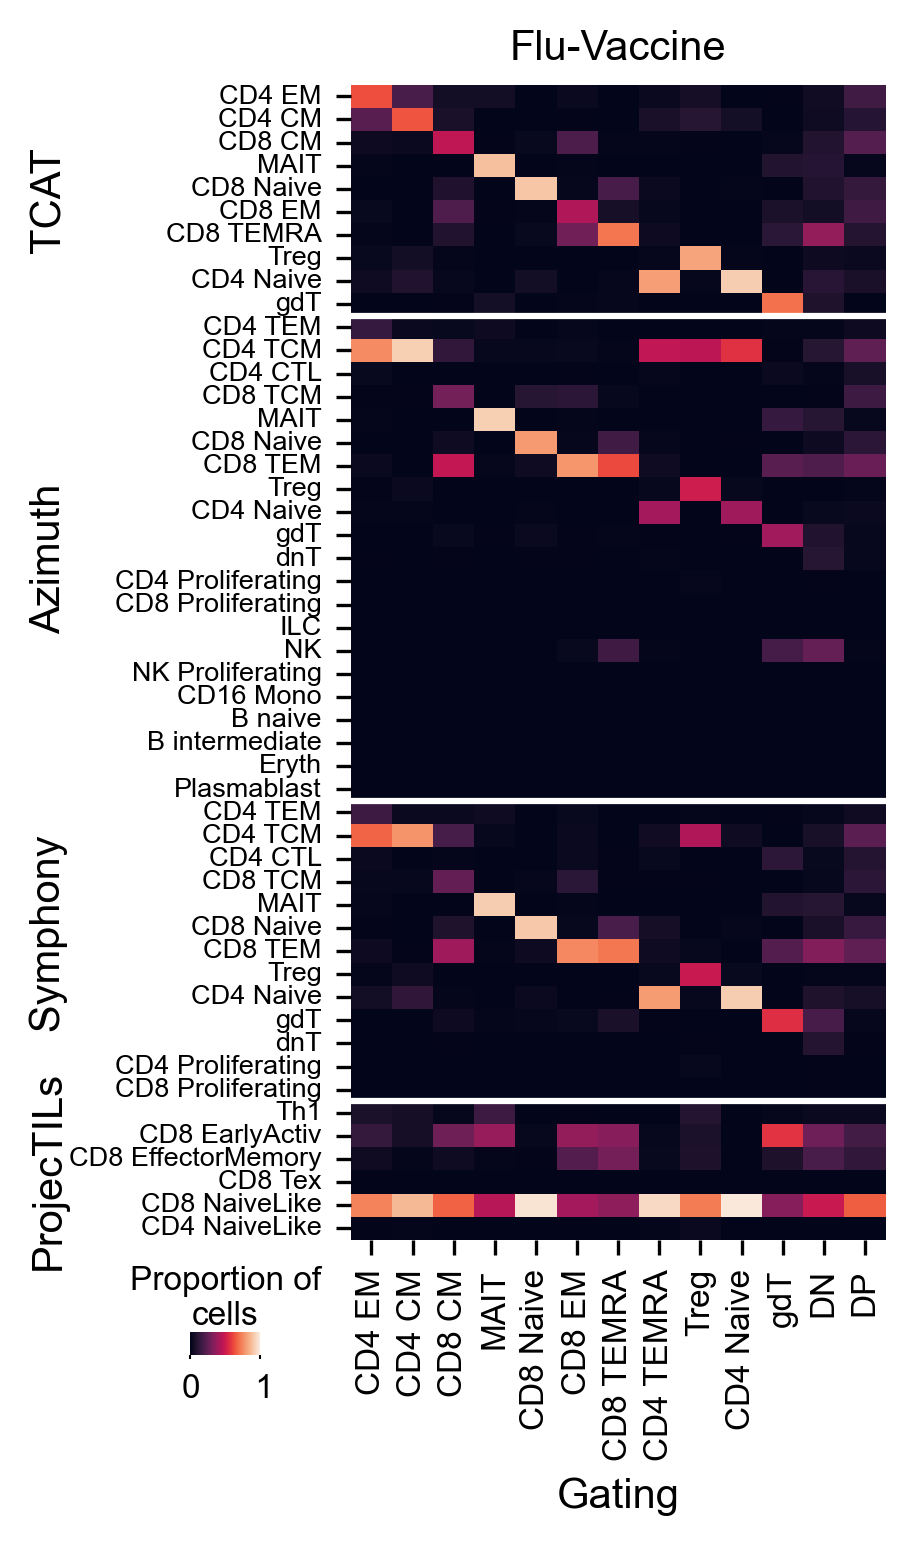

In [66]:
fig, ax = plt.subplots(dpi = 300, figsize = (2.3, 5), 
                      )
cbar_ax = ax.inset_axes([-.3, -.1, 0.13, 0.02], transform=ax.transAxes, xticks=[vmin, vmax])


cbar =True 
g = sns.heatmap(ncells_comp_norm.loc[row_order, col_order], cbar = cbar, 
                cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal", 'ticks':[0, vmax]},
            ax = ax, vmax = vmax, vmin = vmin)
ax.hlines(y = 10, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 31, xmin = 0, xmax = 40, color = 'white')
ax.hlines(y = 44, xmin = 0, xmax = 40, color = 'white')
ax.text(-7.8, 5, 'TCAT', rotation = 90, va = 'center')
ax.text(-7.8, (31-10)/2 +10, 'Azimuth', rotation = 90, va = 'center')
ax.text(-7.8, (44-31)/2 +31, '   Symphony', rotation = 90, va = 'center')
ax.text(-7.8, (len(row_order)-44)/2 +44, 'ProjecTILs', rotation = 90, va = 'center')

ax.tick_params('y', labelsize = tick_fontsize-1.5)
ax.tick_params('x', labelsize = tick_fontsize)
ax.set_xlabel(ax.get_xlabel(), fontsize = label_fontsize)

ax.set_yticks(np.arange(0.5, 0.5+len(row_order_renamed)), row_order_renamed)
ax.set_xticks(np.arange(0.5, 0.5+len(col_order_renamed)), col_order_renamed)
# ax.set_title('%s\nProportion of cells' % dataset_name,  fontsize = label_fontsize)
ax.set_title('%s' % dataset_name,  fontsize = label_fontsize)

cbar_ax.set_xticklabels(['0', ' %.0f' % vmax])
cbar_ax.tick_params(labelsize=8, length=1, width=.5)
cbar_ax.set_title('Proportion of\ncells', fontsize=8, pad=-3)

plt.savefig(os.path.join(figdir, 'Revision_LineageBenchmarkHeatmap_Sparks.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_LineageBenchmarkHeatmap_Sparks.pdf'), bbox_inches="tight")
plt.show()

In [ ]:
import itertools


In [ ]:
comp_all

In [ ]:
usage_thresh = 0.025
# Usage accuracy
# Assign accuracy based on usage thresholding 
for gate_type in gate_list:
    print(gate_type)
    gates = meta_test['cell_gating'] == gate_type # Subset to cells with just relevant gates
    prg = roc.loc[roc['gate']==gate_type, 'program'].unique()[0]
    pred = usage_test.loc[gates.index, prg] > usage_thresh
    accuracy.loc[gate_type, 'usage'] = metrics.balanced_accuracy_score(gates, pred)

accuracy['usage'].mean()

In [79]:
import sklearn

In [ ]:
gates_map = dict(zip(comp_all['Gating'].unique(), [None]*len(comp_all['Gating'].unique())))

gates_map = dict(zip(comp_all['Gating'].unique(), [None]*len(comp_all['Gating'].unique())))
gates_map['CD4_CM'] = [['CD4_CM'], ['CD4 TCM'], ['CD4 TCM'], None]
gates_map['CD4_Naive'] = [['CD4_Naive'], ['CD4 Naive'], ['CD4 Naive'], ['CD4_NaiveLike']]
gates_map['CD4_EM'] = [['CD4_EM'], ['CD4 TEM'], ['CD4 TEM'], ['Tfh', 'Th1']]
gates_map['MAIT'] = [['MAIT'], ['MAIT'], ['MAIT'], None]
gates_map['CD8_CM'] = [['CD8_CM'], ['CD8 TCM'], ['CD8 TCM'], None]
gates_map['CD8_EM'] = [['CD8_EM'], ['CD8 TEM'], ['CD8 TEM'], ['CD8_EffectorMemory']]
gates_map['gdT'] = [['gdT'], ['gdT'], ['gdT'], None]
gates_map['CD8_Naive'] = [['CD8_Naive'], ['CD8 Naive'], ['CD8 Naive'], ['CD8_NaiveLike']]
gates_map['Treg'] = [['Treg'], ['Treg'], ['Treg'], ['Treg']]
gates_map['CD8_TEMRA'] = [['CD8_TEMRA'], None, None, None]
gates_map['DP'] = [None, None, None, None]
gates_map['DN'] = [None, ['dnT'], ['dnT'], None]
gates_map['CD4_TEMRA'] = [None, None, None, None]

In [622]:
(comp_all['Multinomial_Label'].unique(), comp_all['predicted.celltype.l2'].unique(), 
comp_all['cell_type_pred_knn'].unique(), comp_all['ProjecTILsAllT_functional.cluster'].unique(), )

(array(['CD4_Naive', 'CD4_CM', 'CD8_TEMRA', 'CD4_EM', 'CD8_CM', 'Treg',
        'CD8_Naive', 'CD8_EM', 'gdT', 'MAIT'], dtype=object),
 array(['CD4 TCM', 'CD8 TEM', 'CD8 TCM', 'CD4 Naive', 'Treg', 'CD8 Naive',
        'gdT', 'CD4 TEM', 'MAIT', 'Platelet', 'dnT', 'NK', 'Eryth',
        'CD4 CTL', 'CD4 Proliferating', 'NK_CD56bright', 'pDC', 'HSPC',
        'CD14 Mono', 'NK Proliferating', 'CD8 Proliferating',
        'Plasmablast', 'CD16 Mono', 'B naive', 'ILC', 'B intermediate',
        'cDC1', 'B memory'], dtype=object),
 array(['CD4 Naive', 'CD4 TCM', 'CD8 TEM', 'CD8 TCM', 'Treg', 'CD4 TEM',
        'CD8 Naive', 'MAIT', 'gdT', 'CD4 CTL', 'dnT', 'CD4 Proliferating',
        'CD8 Proliferating'], dtype=object),
 array(['CD8_NaiveLike', 'CD8_EarlyActiv', 'Th1', 'CD8_EffectorMemory',
        'CD4_NaiveLike', 'CD8_Tex'], dtype=object))

In [ ]:
accuracy = pd.DataFrame(np.nan, index = comp_all['Gating'].unique(), 
                        columns = ['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn',
                                  'ProjecTILsAllT_functional.cluster'])

In [71]:
comp_all['Multinomial_Label_PredRename'] = ''
comp_all['predicted.celltype.l2_PredRename'] = ''
comp_all['cell_type_pred_knn_PredRename'] = ''
comp_all['ProjecTILsAllT_functional.cluster_PredRename'] = ''

for gate_type in comp_all['Gating'].unique():
    gates = comp_all['Gating']==gate_type
    if gates_map[gate_type][0]:
        pred = comp_all['Multinomial_Label'].isin(gates_map[gate_type][0])
        accuracy.loc[gate_type, 'Multinomial_Label'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['Multinomial_Label'].isin(gates_map[gate_type][0]), 'Multinomial_Label_PredRename'] = gate_type

    if gates_map[gate_type][1]:
        pred = comp_all['predicted.celltype.l2'].isin(gates_map[gate_type][1])
        accuracy.loc[gate_type, 'predicted.celltype.l2'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['predicted.celltype.l2'].isin(gates_map[gate_type][1]), 'predicted.celltype.l2_PredRename'] = gate_type

    if gates_map[gate_type][2]:    
        pred = comp_all['cell_type_pred_knn'].isin(gates_map[gate_type][2])
        accuracy.loc[gate_type, 'cell_type_pred_knn'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['cell_type_pred_knn'].isin(gates_map[gate_type][2]), 'cell_type_pred_knn_PredRename'] = gate_type

    
    if gates_map[gate_type][3]:
        pred = comp_all['ProjecTILsAllT_functional.cluster'].isin(gates_map[gate_type][3])
        accuracy.loc[gate_type, 'ProjecTILsAllT_functional.cluster'] = metrics.balanced_accuracy_score(gates, pred)
        comp_all.loc[comp_all['ProjecTILsAllT_functional.cluster'].isin(gates_map[gate_type][3]), 'ProjecTILsAllT_functional.cluster_PredRename'] = gate_type


In [72]:
accuracy_plot = accuracy.unstack().reset_index()
accuracy_plot.columns = ['name', 'gate', 'value']

In [53]:
accuracy_plot['name'].unique()

array(['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn',
       'ProjecTILsAllT_functional.cluster'], dtype=object)

In [73]:
acc_label_map = {'Multinomial_Label' : 'TCAT', 
                'predicted.celltype.l2' : 'Azimuth',
                'cell_type_pred_knn' : 'Symphony',
                'ProjecTILsAllT_functional.cluster' : 'ProjecTILs'
                }

accuracy_plot['label'] = accuracy_plot['name'].replace(acc_label_map)

/tmp/402154.tmpdir/ipykernel_286447/1328262785.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


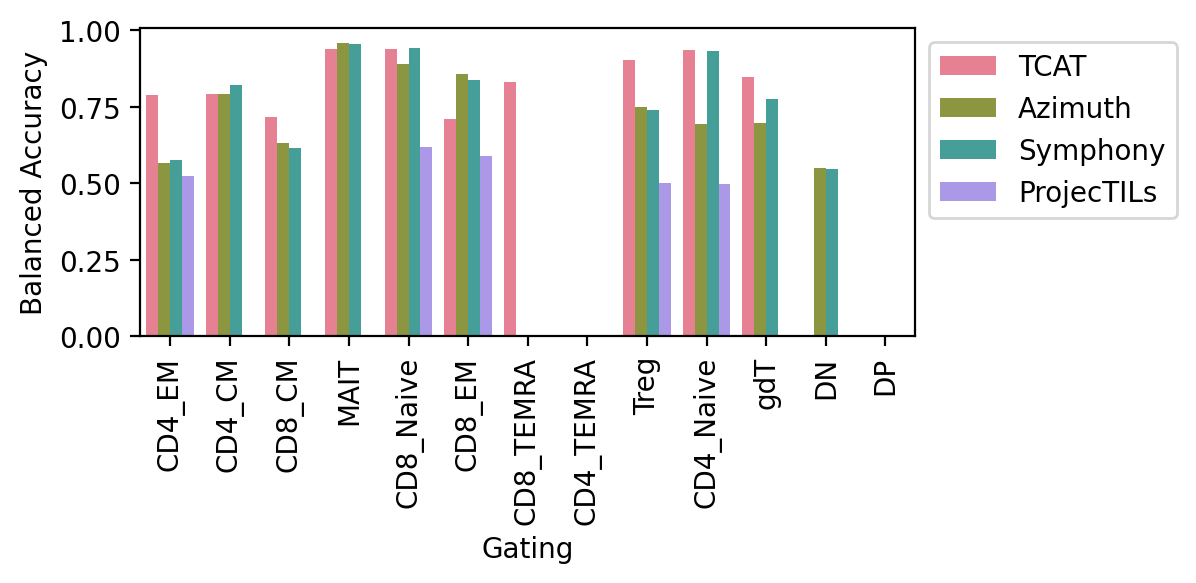

In [55]:
fig, ax = plt.subplots(dpi = 200, figsize = (5, 2))
sns.barplot(data=accuracy_plot, x='gate', y='value', hue='label', 
            order = col_order, #list([x.replace('_', ' ') for x in reversed(gate_order)]),
            ax = ax, palette = sns.color_palette("husl", 4))
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('Gating')
ax.set_ylabel('Balanced Accuracy')
ax.legend(title = '', bbox_to_anchor=(1, 1))

In [60]:
accuracy_plot.fillna(0).groupby('label')['value'].mean()

label
Azimuth       0.567735
ProjecTILs    0.210030
Symphony      0.595434
TCAT          0.646131
Name: value, dtype: float64

In [76]:
accuracy_plot

,name,gate,value,label
0,Multinomial_Label,CD4_Naive,0.933941,TCAT
1,Multinomial_Label,CD4_CM,0.790523,TCAT
2,Multinomial_Label,CD8_EM,0.708997,TCAT
3,Multinomial_Label,CD4_EM,0.789431,TCAT
4,Multinomial_Label,Treg,0.902487,TCAT
5,Multinomial_Label,CD8_TEMRA,0.831846,TCAT
6,Multinomial_Label,CD8_Naive,0.939507,TCAT
7,Multinomial_Label,CD4_TEMRA,NaN,TCAT
8,Multinomial_Label,MAIT,0.938748,TCAT
9,Multinomial_Label,gdT,0.848223,TCAT


In [94]:
accuracy_plot[accuracy_plot['gate']=='CD4_EM']

,name,gate,value,label
3,Multinomial_Label,CD4_EM,0.789431,TCAT
16,predicted.celltype.l2,CD4_EM,0.566640,Azimuth
29,cell_type_pred_knn,CD4_EM,0.575499,Symphony
42,ProjecTILsAllT_functional.cluster,CD4_EM,0.522610,ProjecTILs


In [92]:
accuracy_plot[accuracy_plot['gate']=='CD8_TEMRA']

,name,gate,value,label
5,Multinomial_Label,CD8_TEMRA,0.831846,TCAT
18,predicted.celltype.l2,CD8_TEMRA,NaN,Azimuth
31,cell_type_pred_knn,CD8_TEMRA,NaN,Symphony
44,ProjecTILsAllT_functional.cluster,CD8_TEMRA,NaN,ProjecTILs


In [74]:
# Filter out gates that no models attempt ot predict
gates_filt = ['CD4_TEMRA', 'DP']
comp_all_filt = comp_all[-comp_all['Gating'].isin(gates_filt)]

In [75]:
accuracy_multi = pd.DataFrame(
    [metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['Multinomial_Label_PredRename']),
     metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['predicted.celltype.l2_PredRename']),
    metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['cell_type_pred_knn_PredRename']),
     metrics.balanced_accuracy_score(comp_all_filt['Gating'], comp_all_filt['ProjecTILsAllT_functional.cluster_PredRename'])
    ],
index = ['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn', 'ProjecTILsAllT_functional.cluster'],
    columns = ['value'])
accuracy_multi['name']= accuracy_multi.index
accuracy_multi['label'] = accuracy_multi['name'].replace(acc_label_map)

/PHShome/mc1070/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/PHShome/mc1070/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/PHShome/mc1070/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/tmp/402154.tmpdir/ipykernel_286447/346188771.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


Text(0.5, 1.0, 'Flu-Vaccine')

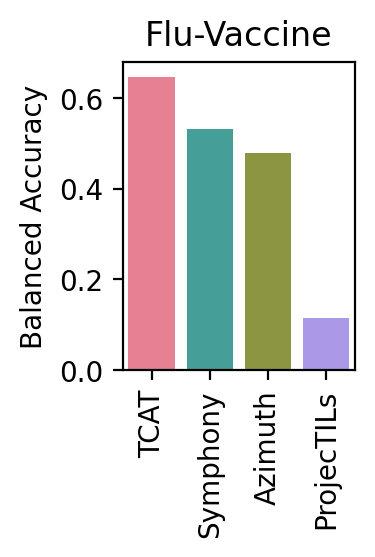

In [85]:
fig, ax = plt.subplots(dpi = 200, figsize = (1.5, 2))
sns.barplot(data=accuracy_multi, x='label', y='value', hue='label', 
            order = ['TCAT', 'Symphony', 'Azimuth', 'ProjecTILs'],
            ax = ax, palette = sns.color_palette("husl", 4))
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('')
ax.set_ylabel('Balanced Accuracy')
ax.set_title(dataset_name)
# ax.legend(title = '', bbox_to_anchor=(1, 1))

In [77]:
# Non-balanced accuracy
accuracy_multi_reg = pd.DataFrame(
    [metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['Multinomial_Label_PredRename']),
     metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['predicted.celltype.l2_PredRename']),
    metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['cell_type_pred_knn_PredRename']),
     metrics.accuracy_score(comp_all_filt['Gating'], comp_all_filt['ProjecTILsAllT_functional.cluster_PredRename'])
    ],
index = ['Multinomial_Label', 'predicted.celltype.l2', 'cell_type_pred_knn', 'ProjecTILsAllT_functional.cluster'],
    columns = ['value'])
accuracy_multi_reg['name']= accuracy_multi_reg.index
accuracy_multi_reg['label'] = accuracy_multi_reg['name'].replace(acc_label_map)

/tmp/402154.tmpdir/ipykernel_286447/3017429338.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


Text(0.5, 1.0, 'Flu-Vaccine')

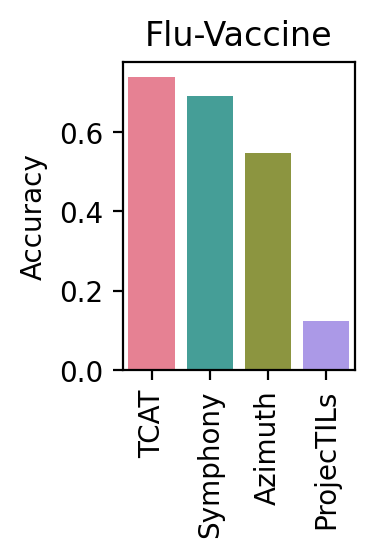

In [87]:
fig, ax = plt.subplots(dpi = 200, figsize = (1.5, 2))
sns.barplot(data=accuracy_multi_reg, x='label', y='value', hue='label', 
            order = ['TCAT', 'Symphony', 'Azimuth', 'ProjecTILs'],
            ax = ax, palette = sns.color_palette("husl", 4))
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title(dataset_name)
# ax.legend(title = '', bbox_to_anchor=(1, 1))

In [78]:
accuracy_multi_all = pd.concat([accuracy_multi, accuracy_multi_reg], keys = ['Balanced Accuracy', 'Accuracy'])
accuracy_multi_all = accuracy_multi_all.reset_index(level = 0)
accuracy_multi_all = accuracy_multi_all.rename({'level_0' : 'type'}, axis = 1)

In [81]:
accuracy_multi_all

,type,value,name,label
Multinomial_Label,Balanced Accuracy,0.647208,Multinomial_Label,TCAT
predicted.celltype.l2,Balanced Accuracy,0.479338,predicted.celltype.l2,Azimuth
cell_type_pred_knn,Balanced Accuracy,0.531402,cell_type_pred_knn,Symphony
ProjecTILsAllT_functional.cluster,Balanced Accuracy,0.115410,ProjecTILsAllT_functional.cluster,ProjecTILs
Multinomial_Label,Accuracy,0.739369,Multinomial_Label,TCAT
predicted.celltype.l2,Accuracy,0.547478,predicted.celltype.l2,Azimuth
cell_type_pred_knn,Accuracy,0.691698,cell_type_pred_knn,Symphony
ProjecTILsAllT_functional.cluster,Accuracy,0.123564,ProjecTILsAllT_functional.cluster,ProjecTILs


/tmp/402154.tmpdir/ipykernel_286447/1203520596.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)


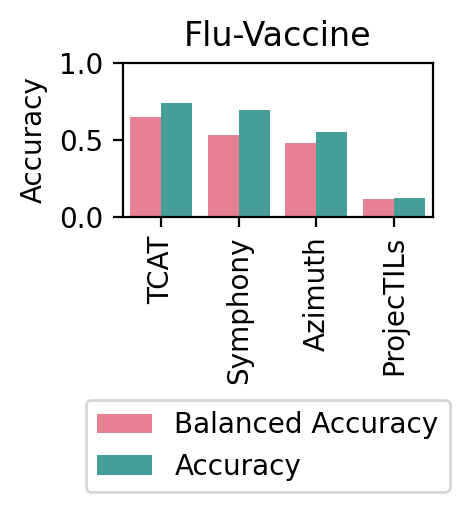

In [89]:
fig, ax = plt.subplots(dpi = 200, figsize = (2, 1))
sns.barplot(data=accuracy_multi_all, x='label', y='value', hue='type', 
            order = ['TCAT', 'Symphony', 'Azimuth', 'ProjecTILs'],
            ax = ax, palette = sns.color_palette("husl", 2)
           )
ax.set_xticklabels(ax.get_xticklabels(), rotation =  90)
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title(dataset_name)
ax.set_ylim([0, 1])
ax.legend(title = '', bbox_to_anchor=(1.1, -1.1))

# plt.savefig(os.path.join(figdir, 'Revision_LineageAccuracy_Sparks.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'Revision_LineageAccuracy_Sparks.pdf'), bbox_inches="tight")
plt.show()

### benchmark AIM status

In [158]:
comp_all[['ASA'] + list(gsetnames)].corr(method = 'pearson')

,ASA,GOBP_ACTIVATED_T_CELL_PROLIFERATION,GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN,GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN,GSE15659_RESTING_VS_ACTIVATED_TREG_DN,GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,WP_TCELL_ACTIVATION_SARSCOV2
ASA,1.000000,0.102171,0.245622,0.055944,0.119933,0.148204,0.125208,0.168156,0.262124,0.167677
GOBP_ACTIVATED_T_CELL_PROLIFERATION,0.102171,1.000000,0.141766,0.063701,0.098867,0.119955,0.106694,0.121816,0.133796,0.171569
GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,0.245622,0.141766,1.000000,0.375982,0.206799,0.254569,0.239783,0.276201,0.373871,0.271858
GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,0.055944,0.063701,0.375982,1.000000,0.212361,0.211853,0.231766,0.228749,0.222994,0.178307
GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.119933,0.098867,0.206799,0.212361,1.000000,0.615007,0.652182,0.588991,0.221167,0.194780
GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.148204,0.119955,0.254569,0.211853,0.615007,1.000000,0.620836,0.667261,0.301227,0.197607
GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN,0.125208,0.106694,0.239783,0.231766,0.652182,0.620836,1.000000,0.654141,0.252918,0.229781
GSE15659_RESTING_VS_ACTIVATED_TREG_DN,0.168156,0.121816,0.276201,0.228749,0.588991,0.667261,0.654141,1.000000,0.323773,0.246468
GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,0.262124,0.133796,0.373871,0.222994,0.221167,0.301227,0.252918,0.323773,1.000000,0.218467
WP_TCELL_ACTIVATION_SARSCOV2,0.167677,0.171569,0.271858,0.178307,0.194780,0.197607,0.229781,0.246468,0.218467,1.000000


In [157]:
comp_all[['ASA'] + list(gsetnames)].corr(method = 'spearman')

,ASA,GOBP_ACTIVATED_T_CELL_PROLIFERATION,GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN,GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN,GSE15659_RESTING_VS_ACTIVATED_TREG_DN,GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,WP_TCELL_ACTIVATION_SARSCOV2
ASA,1.000000,0.106551,0.216449,0.013889,0.092175,0.155107,0.099409,0.163807,0.335154,0.141948
GOBP_ACTIVATED_T_CELL_PROLIFERATION,0.106551,1.000000,0.143891,0.065275,0.100493,0.132714,0.110706,0.133210,0.170907,0.173090
GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,0.216449,0.143891,1.000000,0.345769,0.194672,0.253375,0.224963,0.266965,0.378717,0.253871
GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,0.013889,0.065275,0.345769,1.000000,0.197913,0.200450,0.211662,0.211282,0.219137,0.166045
GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.092175,0.100493,0.194672,0.197913,1.000000,0.591776,0.625755,0.553558,0.232254,0.195475
GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.155107,0.132714,0.253375,0.200450,0.591776,1.000000,0.616168,0.662581,0.334015,0.204993
GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN,0.099409,0.110706,0.224963,0.211662,0.625755,0.616168,1.000000,0.632316,0.259777,0.228601
GSE15659_RESTING_VS_ACTIVATED_TREG_DN,0.163807,0.133210,0.266965,0.211282,0.553558,0.662581,0.632316,1.000000,0.342894,0.249261
GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,0.335154,0.170907,0.378717,0.219137,0.232254,0.334015,0.259777,0.342894,1.000000,0.245683
WP_TCELL_ACTIVATION_SARSCOV2,0.141948,0.173090,0.253871,0.166045,0.195475,0.204993,0.228601,0.249261,0.245683,1.000000


In [584]:
comp_all['Activated'].value_counts()

Activated
Unactivated    331654
Activated        4252
Name: count, dtype: int64

In [83]:
ind = comp_all.index #comp_all[comp_all['Activated'].isin(['Activated'])].index

In [84]:
from sklearn.metrics import roc_curve, roc_auc_score

In [85]:
fprs = {}
tprs = {}
aucs = {}

# for c in ['ASA']+ list(gsetnames):
#     fpr, tpr, thresholds = roc_curve(comp_all.loc[ind, 'Sort_Status']=='+', comp_all.loc[ind, c])
#     auc = roc_auc_score(comp_all.loc[ind, 'Sort_Status']=='+', comp_all.loc[ind, c])
#     fprs[c], tprs[c], aucs[c] = fpr, tpr, auc

In [86]:
label_fontsize = 10

In [87]:
lineage_classes = ['CD4 Conv', 'CD4 Treg', 'CD8 Conv', 'Other']

In [88]:
for c in ['ASA']+ list(gsetnames):
    fprs[c], tprs[c], aucs[c] = {}, {}, {}
    
    for lineage in lineage_classes + ['All']:
        if lineage == 'All':
            overlap_lineage = ind
        else:
            overlap_lineage = comp_all.loc[ind, :][comp_all.loc[ind, 'Gating_Class']==lineage].index


        fpr, tpr, thresholds = roc_curve(comp_all.loc[overlap_lineage, 'Activated']=='Activated', 
                                         comp_all.loc[overlap_lineage, c])
        auc = roc_auc_score(comp_all.loc[overlap_lineage, 'Activated']=='Activated', 
                            comp_all.loc[overlap_lineage, c])
        fprs[c][lineage], tprs[c][lineage], aucs[c][lineage] = fpr, tpr, auc

Text(0.5, 1.1, 'Sparks')

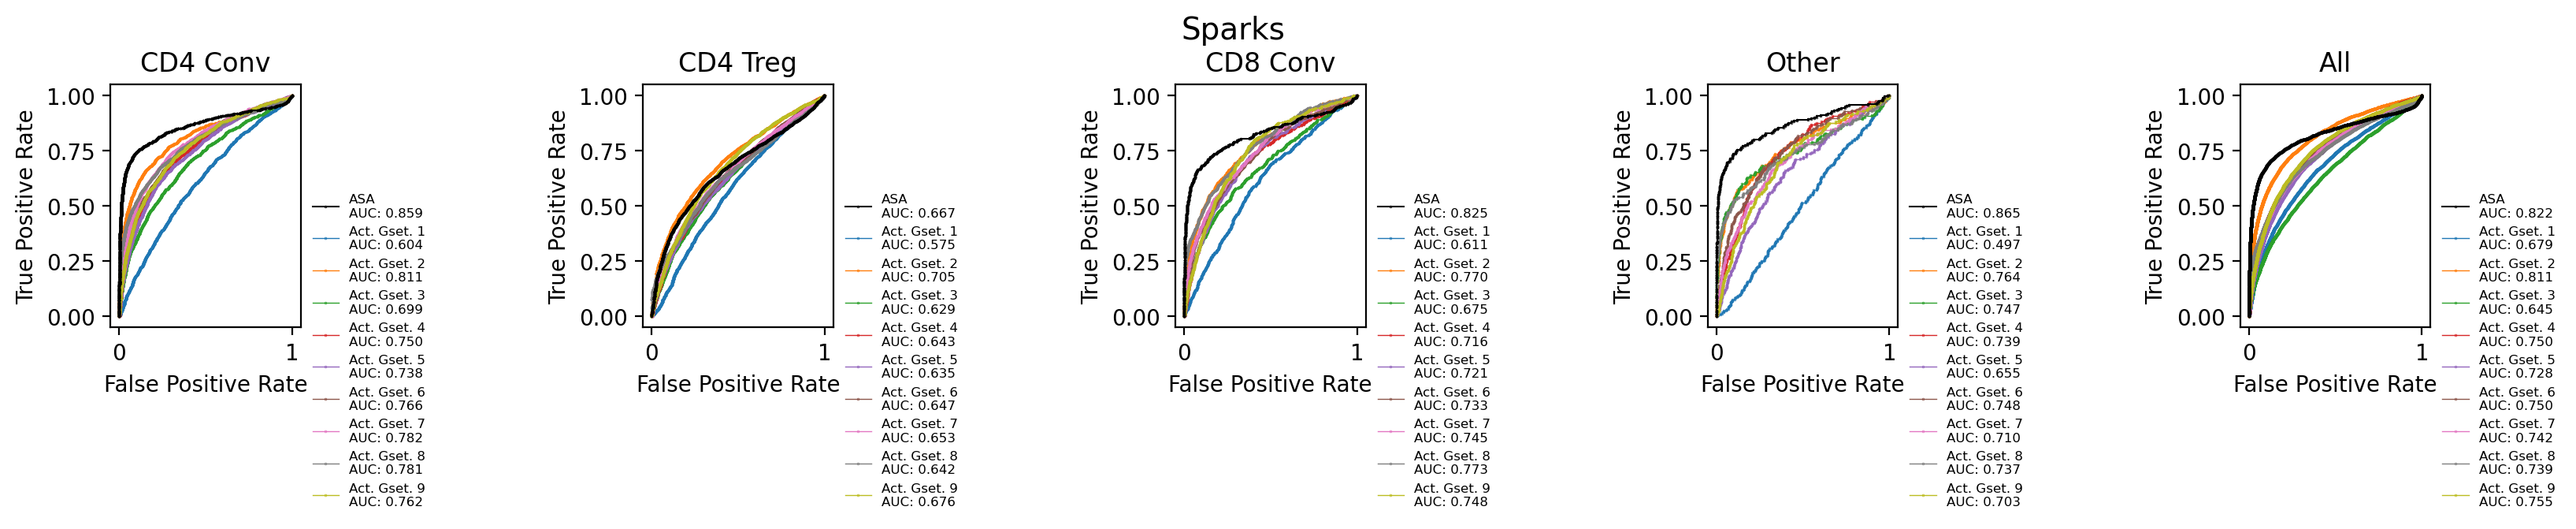

In [306]:
fig, axes = plt.subplots(dpi = 200, ncols = len(lineage_classes) + 1, figsize = (19, 2),
                        gridspec_kw = {'wspace' : 1.8})
for n, lineage in enumerate(lineage_classes + ['All']):

    ax = axes[n]

    for z, c in enumerate(['ASA']+ list(gsetnames)):
        # print(label)
        if c=='ASA':
            label = c
        else:
            label = 'Act. Gset. %i' % z
        fpr, tpr, auc = fprs[c][lineage], tprs[c][lineage], aucs[c][lineage]


        ax.set_xlabel('False Positive Rate', fontsize = label_fontsize)
        ax.set_ylabel('True Positive Rate', fontsize = label_fontsize)
        if c=='ASA':
            ax.plot(fpr, tpr, marker='.', color = 'black', 
                 zorder = 10, linewidth = .75, ms = .5,
                 label = '%s\nAUC: %.3f' %(label, auc))#'%s AUC: %.3f' % (c, auc))

        else:
            ax.plot(fpr, tpr, marker='.',# color = 'cornflowerblue', 
                     zorder = 3, linewidth = .5, ms = .5,
                     label = '%s\nAUC: %.3f' %(label, auc))#'%s AUC: %.3f' % (c, auc))

    # handles, labels = 
    # print(ax.get_legend_handles_labels())
    # ax.legend(handles[:4], labels[:4], fontsize=7, frameon=False, bbox_to_anchor=(1, 1))

    ax.legend(fontsize = 6, frameon=False, bbox_to_anchor = (1, .6))
    ax.set_title(lineage)
plt.suptitle(dataset, y = 1.1, fontsize = 14)

In [90]:
gsetnames_short = dict(zip(['ASA']+ list(gsetnames), ['ASA']+ list(gsetnames)))

In [99]:
# gsetnames_short ={'ASA':'ASA',
#     'GOBP_ACTIVATED_T_CELL_PROLIFERATION': 'GOBP_ACT._TCELL_PROLIF.',
#  'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN': 'GSE13738_REST._VS_TCR_ACT._CD4',
#  'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP': 'GSE13738_TCR_VS_BYSTD._ACT._CD4',
#  'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_CD45RA-CD4_VS_ACT.TREG',
#  'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_NAIVE_CD4_VS_ACT.TREG',
#  'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_NSUPP._VS_ACT.TREG',
#  'GSE15659_RESTING_VS_ACTIVATED_TREG_DN': 'GSE15659_REST._VS_ACT.TREG',
#  'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN': 'GSE28726_NAIVE_VS_ACT._CD4',
#  'WP_TCELL_ACTIVATION_SARSCOV2': 'WP_TCELL_ACT._SARSCOV2'}


gsetnames_short ={'ASA':'ASA',
    'GOBP_ACTIVATED_T_CELL_PROLIFERATION': 'GOBP_ACT',
 'GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN': 'GSE13738_RVT',
 'GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP': 'GSE13738_TVB',
 'GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_CVA',
 'GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_NAVA',
 'GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN': 'GSE15659_NSVA',
 'GSE15659_RESTING_VS_ACTIVATED_TREG_DN': 'GSE15659_RVA',
 'GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN': 'GSE28726_NVA',
 'WP_TCELL_ACTIVATION_SARSCOV2': 'WP_ACTCOV'}


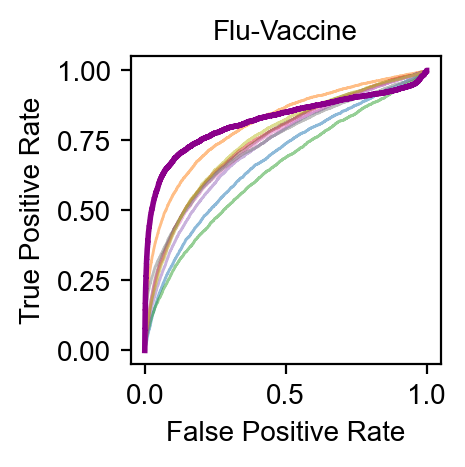

In [103]:
fig, ax = plt.subplots(dpi = 200, 
                       figsize = (2, 2),
                        gridspec_kw = {'wspace' : 1.8})
n = 0 
lineage = 'All'


for z, c in enumerate(['ASA']+ list(gsetnames)):
    # print(label)
    if c=='ASA':
        label = c
    else:
        label = gsetnames_short[c] #'%s.' % c[0:c[0:20].rfind('_')]
    fpr, tpr, auc = fprs[c][lineage], tprs[c][lineage], aucs[c][lineage]


    ax.set_xlabel('False Positive Rate', fontsize = label_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize = label_fontsize)
    if c=='ASA':
        ax.plot(fpr, tpr, color = 'darkmagenta', 
             zorder = 10, linewidth = 2,# ms = .5,
             label = '%s' %(label))#'%s AUC: %.3f' % (c, auc))

    else:
        ax.plot(fpr, tpr, #marker='.',# color = 'cornflowerblue', 
                 zorder = 3, linewidth = 1, alpha = 0.5,
                 label = '%s' %(label))#'%s AUC: %.3f' % (c, auc))

# handles, labels = 
# print(ax.get_legend_handles_labels())
# ax.legend(handles[:4], labels[:4], fontsize=7, frameon=False, bbox_to_anchor=(1, 1))

ax.legend(fontsize = 6, frameon=False, bbox_to_anchor = (1, 1))
ax.get_legend().remove()
ax.set_title(dataset_name, fontsize = label_fontsize)

plt.savefig(os.path.join(figdir, 'Revision_ActivationROC_Sparks.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_ActivationROC_Sparks.pdf'), bbox_inches="tight")
plt.show()

In [124]:
gset_cmap = dict(zip(gsetnames,
                    ['silver']*len(gsetnames)))
gset_cmap['ASA'] = 'dimgrey'

In [107]:
aucs_df = pd.DataFrame.from_dict(aucs)
aucs_plot = pd.DataFrame(aucs_df.loc['All', :].sort_values(ascending = False))
aucs_plot['label'] = aucs_plot.index.map(gsetnames_short)

In [1043]:
aucs_plot

,All,label
ASA,0.822398,ASA
GSE13738_RESTING_VS_TCR_ACTIVATED_CD4_TCELL_DN,0.811103,GSE13738_REST._VS_TCR_ACT._CD4
WP_TCELL_ACTIVATION_SARSCOV2,0.754619,WP_TCELL_ACT._SARSCOV2
GSE15659_NONSUPPRESSIVE_TCELL_VS_ACTIVATED_TREG_DN,0.750241,GSE15659_NSUPP._VS_ACT.TREG
GSE15659_CD45RA_NEG_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.750090,GSE15659_CD45RA-CD4_VS_ACT.TREG
GSE15659_RESTING_VS_ACTIVATED_TREG_DN,0.741668,GSE15659_REST._VS_ACT.TREG
GSE28726_NAIVE_VS_ACTIVATED_CD4_TCELL_DN,0.738648,GSE28726_NAIVE_VS_ACT._CD4
GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN,0.728266,GSE15659_NAIVE_CD4_VS_ACT.TREG
GOBP_ACTIVATED_T_CELL_PROLIFERATION,0.679034,GOBP_ACT._TCELL_PROLIF.
GSE13738_TCR_VS_BYSTANDER_ACTIVATED_CD4_TCELL_UP,0.644507,GSE13738_TCR_VS_BYSTD._ACT._CD4


/tmp/ipykernel_222298/745730203.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


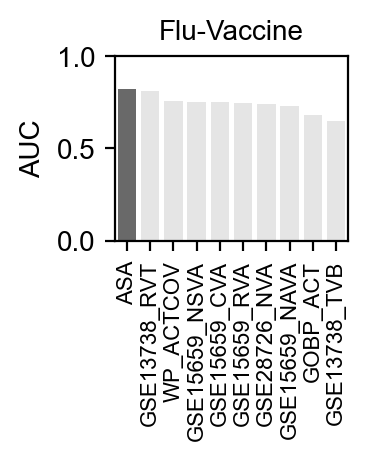

In [126]:
fig, ax = plt.subplots(dpi = 200, figsize = (1.5, 1.2))
sns.barplot(data=aucs_plot, x='label', y='All', hue='label', 
            # order = aims,
            ax = ax, palette = [gset_cmap[x] for x in aucs_plot.index], 
            alpha = 0.4,
           )
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation =  90, fontsize = tick_fontsize, 
                   # rotation_mode="anchor", ha = 'right'
                  )
ax.set_xlabel('')
ax.set_ylabel('AUC')
ax.set_ylim([0, 1])
ax.set_title(dataset_name, fontsize = label_fontsize)
# ax.containers[0].set_alpha(1)

ax.containers[0][0].set_alpha(1)

plt.savefig(os.path.join(figdir, 'Revision_ActivationAUCs_Sparks.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Revision_ActivationAUCs_Sparks.pdf'), bbox_inches="tight")
plt.show()